In [1]:
# Import
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import requests
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_sp500_tickers():
    """Guncel S&P 500 Listesini cekelim."""

    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    
    headers = {
        "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7)"
    }

    response = requests.get(url, headers=headers)
    response.raise_for_status()
    
    tables = pd.read_html(response.text)
    df = tables[0]
    
    tickers = df['Symbol'].tolist()
    # Stock Price isimlendirme duzeltmesi
    tickers = [t.replace('.', '-') for t in tickers]
    return tickers

tickers = get_sp500_tickers()
print("",len(tickers), "\n",tickers[:10])

 501 
 ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


In [3]:
def download_data(start_date, end_date, tickers):
    """
    Belirtilen tarih araliginda Adjusted Close ve Volume verilerini indirelim.
    """
    print(f"{len(tickers)} hisse icin veri indiriliyor...")

    # yfinance ile verileri indirelim.
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)

    prices = data.xs('Close', level=1, axis=1)
    volumes = data.xs('Volume', level=1, axis=1)
    return prices, volumes


# Tarih aralığı
START_DATE = "2010-01-01"
END_DATE   = "2024-12-31"

# S&P 500 güncel tickersları alalım.
tickers = get_sp500_tickers()

# Fiyat ve volume datasını çekelim.
prices_df, volumes_df = download_data(START_DATE, END_DATE, tickers)

# Eksik verisi olan stock price'ları çıkaralım. (Burada survivorship bias oluşturuyoruz ancak bunu raporumuz ekleriz.)
valid_columns = prices_df.columns[prices_df.notna().sum() > (len(prices_df) * 0.8)]
prices_df = prices_df[valid_columns]
volumes_df = volumes_df[valid_columns]

print("Veriler indirildi.")
print(f"prices_df.shape: {prices_df.shape}")
print(prices_df.head())


# prices_df.to_csv("sp500_prices_2010_2024.csv")
# volumes_df.to_csv("sp500_volumes_2010_2024.csv")

501 hisse icin veri indiriliyor...


[*********************100%***********************]  501 of 501 completed

3 Failed downloads:
['SOLS', 'Q', 'SNDK']: YFPricesMissingError('possibly delisted; no price data found  (1d 2010-01-01 -> 2024-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 1262322000, endDate = 1735621200")')


Veriler indirildi.
prices_df.shape: (3773, 446)
Ticker            TFC         F        AON       BALL      IBKR       PSKY  \
Date                                                                         
2010-01-04  14.732955  5.287394  32.125523  11.230810  3.400005  10.735094   
2010-01-05  14.944160  5.637145  31.922298  11.104574  3.323385  10.682361   
2010-01-06  15.259915  5.848022  31.913826  11.125969  3.334877  10.343359   
2010-01-07  15.874218  5.997181  31.820688  11.100295  3.355950  10.546758   
2010-01-08  15.696240  6.012610  32.083183  11.140949  3.306146  10.659765   

Ticker            UNP  AXON        DVA        VMC  ...        CAG         MA  \
Date                                               ...                         
2010-01-04  23.174585  4.65  29.959999  45.854374  ...  10.395190  23.617977   
2010-01-05  23.497097  4.70  29.705000  46.028286  ...  10.440169  23.548092   
2010-01-06  23.532541  5.84  29.530001  46.828327  ...  10.404186  23.514044   
2010-

In [4]:
def calculate_returns(prices_df):
    """
    Calculate log returns.
    """
    returns = np.log(prices_df / prices_df.shift(1))
    return returns.dropna()

def get_pca_residuals(returns_df, n_components=5, window=252):

    residuals = pd.DataFrame(index=returns_df.index, columns=returns_df.columns)
    residuals[:] = np.nan # Başlangıçta boş

    print(f"PCA Residual hesaplanıyor... (Toplam {len(returns_df) - window} gün işlenecek)")
    
    # veri setini array'lere dönüştürelim.
    data_values = returns_df.values
    index_values = returns_df.index
    columns_values = returns_df.columns

    # PCA Modeli
    pca = PCA(n_components=n_components)

    # Döngü: Her gün için geçmiş 'window' kadar veriyi alıp PCA uygula.
    for t in range(window, len(returns_df)):
        
        # Geçmiş veriyi al (t-window'dan t'ye kadar)
        window_data = data_values[t-window : t]
        
        # Sütun bazında NaN var mı kontrol et (Bazen hisseler o dönem işlem görmemiş olabilir)
        # Basitlik adına: O pencerede hiç NaN olmayan hisseleri seçelim
        valid_idx = ~np.isnan(window_data).any(axis=0)
        
        if np.sum(valid_idx) < n_components + 1:
            continue # Yeterli hisse yoksa atla
            
        clean_data = window_data[:, valid_idx]
        
        # PCA Uygula (Faktörleri bul)
        pca.fit(clean_data)
        
        # O günün (t anı) getirisini tahmin et
        # Faktör Yükleri (Betas) = pca.components_
        # Faktör Getirileri = O günün getirisi * Betas (Projeksiyon)
        
        current_returns = data_values[t, valid_idx].reshape(1, -1)
        
        # PCA dönüşümü: Veriyi faktör uzayına indirge
        factors = pca.transform(current_returns) 
        
        # Ters dönüşüm: Faktörlerden tekrar getiri uzayına çık (Reconstruction)
        reconstructed_returns = pca.inverse_transform(factors)
        
        # Artık (Residual) = Gerçek - Tahmin
        res = current_returns - reconstructed_returns
        
        # Sonucu kaydet
        residuals.iloc[t, valid_idx] = res.flatten()

    return residuals

In [5]:
returns_df = calculate_returns(prices_df)

# Cap outliers
# returns_df = returns_df.clip(lower=returns_df.quantile(0.05), upper=returns_df.quantile(0.95), axis=1)

# Calculate residuals
residuals_df = get_pca_residuals(returns_df, n_components=5, window=252) # window size 252 - 500 denenebilir.

for col in residuals_df.columns:
    residuals_df[col] = residuals_df[col].astype(np.float64)

residuals_df = residuals_df.dropna(how='all')
print(residuals_df.tail())

PCA Residual hesaplanıyor... (Toplam 2766 gün işlenecek)
Ticker           TFC         F       AON      BALL      IBKR      PSKY  \
Date                                                                     
2024-12-23  0.003714  0.000102  0.001076 -0.001491  0.004498 -0.028645   
2024-12-24 -0.003516  0.001215  0.002793  0.001380  0.003304  0.005839   
2024-12-26 -0.001451  0.003757 -0.000580 -0.000191  0.001676 -0.001172   
2024-12-27  0.003076  0.006310  0.002997  0.001119 -0.005076 -0.003057   
2024-12-30  0.003390 -0.001376 -0.001961 -0.003795  0.001130  0.003593   

Ticker           UNP      AXON       DVA       VMC  ...       CAG        MA  \
Date                                                ...                       
2024-12-23  0.004301 -0.013965  0.005859 -0.003084  ...  0.019262  0.001317   
2024-12-24  0.003884 -0.003079  0.005005 -0.004053  ...  0.002343  0.005411   
2024-12-26  0.001865 -0.012472  0.002161  0.000183  ... -0.004623  0.000575   
2024-12-27  0.006377 -0.00802

--- Özet İstatistikler ---
Ortalama Varyans Açıklama Oranı (R^2): %47.75
(Yani hisse hareketlerinin %48'i piyasa faktörlerinden kaynaklıydı ve temizlendi.)
Ortalama Piyasa Korelasyonu (Ham Getiri): 0.592
Ortalama Piyasa Korelasyonu (Residuals):  0.011 (Sıfıra yakın olmalı)


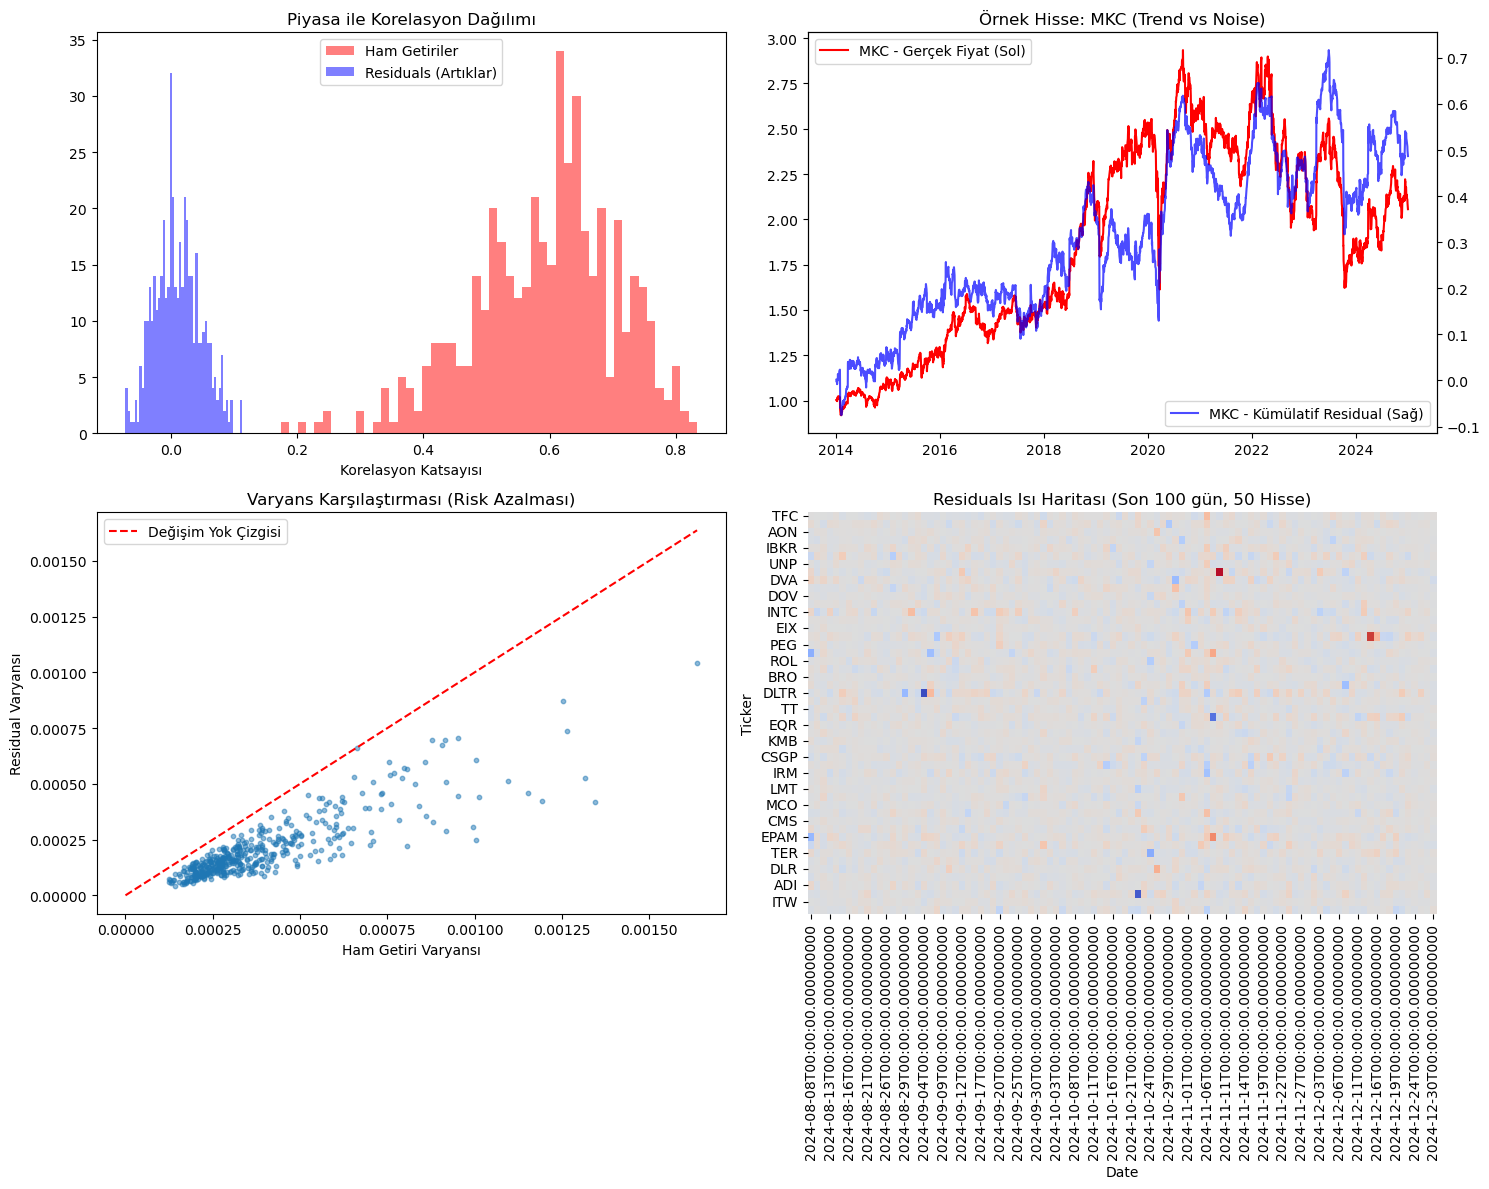

In [6]:
#
def analyze_residuals(returns_df, residuals_df):
    """
    Orijinal getiriler ile PCA sonrası artıkları (residuals) karşılaştırır.
    """
    
    # Ortak tarihleri hizalayalım (Residuals ilk window kadar boştur)
    valid_dates = residuals_df.dropna(how='all').index
    ret_clean = returns_df.loc[valid_dates]
    res_clean = residuals_df.loc[valid_dates]
    
    # Piyasa Proxy'si Oluşturma (Equal Weighted Index)
    # S&P 500 endeks verisi yerine, elimizdeki hisselerin ortalamasını "Piyasa" kabul edelim.
    market_return = ret_clean.mean(axis=1)
    
    # Varyans Azalması (R-Kare Benzeri Analiz)
    # Formül: 1 - (Var(Residual) / Var(Raw))
    # Bu bize "PCA faktörleri varyansın % kaçını açıkladı?" bilgisini verir.
    var_raw = ret_clean.var()
    var_res = res_clean.var()
    variance_explained = 1 - (var_res / var_raw)
    
    print(f"--- Özet İstatistikler ---")
    print(f"Ortalama Varyans Açıklama Oranı (R^2): %{variance_explained.mean()*100:.2f}")
    print(f"(Yani hisse hareketlerinin %{variance_explained.mean()*100:.0f}'i piyasa faktörlerinden kaynaklıydı ve temizlendi.)")
    
    # Piyasa ile Korelasyon Analizi
    # Her bir hissenin piyasa ile korelasyonunu hesapla
    corr_raw = ret_clean.corrwith(market_return)
    corr_res = res_clean.corrwith(market_return)
    
    print(f"Ortalama Piyasa Korelasyonu (Ham Getiri): {corr_raw.mean():.3f}")
    print(f"Ortalama Piyasa Korelasyonu (Residuals):  {corr_res.mean():.3f} (Sıfıra yakın olmalı)")

    # Görselleştirme
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Grafik A: Korelasyon Dağılımı (Histogram)
    axes[0, 0].hist(corr_raw, bins=50, alpha=0.5, label='Ham Getiriler', color='red')
    axes[0, 0].hist(corr_res, bins=50, alpha=0.5, label='Residuals (Artıklar)', color='blue')
    axes[0, 0].set_title('Piyasa ile Korelasyon Dağılımı')
    axes[0, 0].legend()
    axes[0, 0].set_xlabel('Korelasyon Katsayısı')
    
    # Grafik B: Rastgele Bir Hissenin Kümülatif Getirisi vs Residual
    # Rastgele bir hisse seçelim
    sample_stock = ret_clean.columns[np.random.randint(0, len(ret_clean.columns))]
    
    cum_ret = (1 + ret_clean[sample_stock]).cumprod()
    cum_res = res_clean[sample_stock].cumsum() # Residuals log-return olduğu için toplanır (yaklaşık)
    
    ax2 = axes[0, 1]
    ax2.plot(cum_ret.index, cum_ret, label=f'{sample_stock} - Gerçek Fiyat (Sol)', color='red')
    ax2_r = ax2.twinx()
    ax2_r.plot(cum_res.index, cum_res, label=f'{sample_stock} - Kümülatif Residual (Sağ)', color='blue', alpha=0.7)
    ax2.set_title(f'Örnek Hisse: {sample_stock} (Trend vs Noise)')
    ax2.legend(loc='upper left')
    ax2_r.legend(loc='lower right')
    
    # Grafik C: Volatilite Karşılaştırması
    axes[1, 0].scatter(var_raw, var_res, alpha=0.5, s=10)
    axes[1, 0].plot([0, var_raw.max()], [0, var_raw.max()], 'r--', label='Değişim Yok Çizgisi')
    axes[1, 0].set_title('Varyans Karşılaştırması (Risk Azalması)')
    axes[1, 0].set_xlabel('Ham Getiri Varyansı')
    axes[1, 0].set_ylabel('Residual Varyansı')
    axes[1, 0].legend()
    
    # Grafik D: Residual Isı Haritası (İlk 50 hisse, son 100 gün)
    # Kümeleşme var mı diye bakıyoruz
    import seaborn as sns
    sns.heatmap(res_clean.iloc[-100:, :50].T, ax=axes[1, 1], cmap='coolwarm', center=0, cbar=False)
    axes[1, 1].set_title('Residuals Isı Haritası (Son 100 gün, 50 Hisse)')
    
    plt.tight_layout()
    plt.show()


analyze_residuals(returns_df, residuals_df)

# Model

In [7]:
from tqdm import tqdm
def create_sequences(residuals_df, window_size=30):
    """
    Residuals DataFrame'ini Derin Öğrenme için (Samples, TimeSteps, Features) formatına çevirir.
    Ayrıca her pencereyi kendi içinde normalize eder (Local Normalization).
    """
    
    # DataFrame'i Numpy'a çevir (İşlem hızı için)
    data = residuals_df.values
    num_days, num_stocks = data.shape
    
    X_list = []
    y_list = []
    
    print(f"Veri seti oluşturuluyor... (Hisse Sayısı: {num_stocks}, Gün Sayısı: {num_days})")
    
    # Her hisse için döngü (Sütun sütun geziyoruz)
    for stock_idx in tqdm(range(num_stocks)):
        stock_data = data[:, stock_idx]
        
        # O hissede çok fazla NaN varsa atla (Temizlik)
        if np.isnan(stock_data).sum() > len(stock_data) * 0.1:
            continue
            
        # Kayan Pencere (Rolling Window) Oluşturma
        for t in range(window_size, num_days):
            
            # Girdi: t-30'dan t'ye kadar olan kısım
            input_window = stock_data[t-window_size : t]
            
            # Hedef: t anındaki (bir sonraki günün) getiri
            target = stock_data[t]
            
            # Eğer pencerede veya hedefte NaN varsa bu örneği atla
            if np.isnan(input_window).any() or np.isnan(target):
                continue
            
            # STANDARDİZASYON
            # her pencereyi kendi içinde normalize ediyoruz (Mean=0, Std=1)
            window_mean = np.mean(input_window)
            window_std = np.std(input_window)
            
            # Sıfıra bölme hatasını önle (Eğer veri sabitse std=0 olur)
            if window_std < 1e-8:
                continue
                
            normalized_window = (input_window - window_mean) / window_std
            
            X_list.append(normalized_window)
            
            # Hedef veriyi normalize ETMİYORUZ çünkü gerçek getiri (pnl) hesabında orijinal büyüklük lazım.
            # ANCAK: Loss fonksiyonunda scale sorunu yaşamamak için target'ı da bazen scale etmek gerekebilir.
            # Makale stratejisinde, target genellikle ham bırakılır veya global bir katsayı ile ölçeklenir.
            # Biz şimdilik ham (raw) bırakalım.
            y_list.append(target)

    # Listeleri Numpy Array'e çevir ve boyutlandır
    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.float32)
    
    # X Boyutunu (Samples, 30) -> (Samples, 30, 1) yapalım (CNN 3D input ister: Batch, Time, Channel)
    X = np.expand_dims(X, axis=-1)
    
    return X, y

# --- UYGULAMA ---
# residuals_df'inizin hazır olduğunu varsayıyorum.

X, y = create_sequences(residuals_df, window_size=30)

print(f"\nVeri Seti Hazırlandı!")
print(f"Girdi Boyutu (X): {X.shape}") # Örn: (1500000, 30, 1)
print(f"Hedef Boyutu (y): {y.shape}") # Örn: (1500000,)

Veri seti oluşturuluyor... (Hisse Sayısı: 446, Gün Sayısı: 2766)


100%|██████████| 446/446 [00:15<00:00, 29.14it/s]



Veri Seti Hazırlandı!
Girdi Boyutu (X): (1220256, 30, 1)
Hedef Boyutu (y): (1220256,)


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- 1. MODEL MİMARİSİ (CNN + Transformer) ---
class ArbitrageModel(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(ArbitrageModel, self).__init__()
        
        # 1. CNN Bloğu (Yerel Özellik Çıkarıcı)
        # Girdi: (Batch, 1, 30) -> Kanal sayısı 1 (Sadece Residual)
        # Çıktı: (Batch, d_model, 30) -> Özellik haritasına dönüştürme
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=d_model, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
        # 2. Transformer Bloğu (Global Zaman İlişkisi)
        # PyTorch Transformer varsayılan olarak (Seq, Batch, Feature) ister.
        # batch_first=True diyerek (Batch, Seq, Feature) kullanacağız.
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 3. Çıktı Katmanı (Trading Policy)
        # Transformer çıktısını tek bir skora (ağırlığa) dönüştürür.
        self.decoder = nn.Sequential(
            nn.Linear(d_model * 30, 128), # Tüm zaman adımlarını düzleştirip alıyoruz
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1) # Tek bir çıktı: Pozisyon Ağırlığı (w)
        )
        
    def forward(self, x):
        # x shape: (Batch, 30, 1)
        
        # CNN için boyut değişimi: (Batch, Channel, Time) -> (Batch, 1, 30)
        x = x.permute(0, 2, 1)
        
        # CNN Uygula
        x = self.conv1(x) # -> (Batch, d_model, 30)
        x = self.relu(x)
        
        # Transformer için boyut değişimi: (Batch, Time, Feature) -> (Batch, 30, d_model)
        x = x.permute(0, 2, 1)
        
        # Transformer Uygula
        x = self.transformer_encoder(x) # -> (Batch, 30, d_model)
        
        # Düzleştir (Flatten)
        x = x.reshape(x.size(0), -1) # -> (Batch, 30 * d_model)
        
        # Son Karar (Output)
        out = self.decoder(x) # -> (Batch, 1)
        
        # Tanh aktivasyonu: Çıktıyı -1 ile +1 arasına sıkıştırır (Short / Long limiti)
        # Makalede genelde kısıtlamasız çıktı alınıp sonra normalize edilir ama
        # tanh kullanmak eğitimi stabilize eder.
        return torch.tanh(out) 

# --- 2. ÖZEL KAYIP FONKSİYONU (Sharpe Loss) ---
class SharpeLoss(nn.Module):
    """
    Yapay Zeka normalde hatayı (MSE) minimize eder.
    Ancak biz karı/riski (Sharpe Ratio) maksimize etmek istiyoruz.
    Bu yüzden Loss = -Sharpe Ratio olarak tanımlıyoruz.
    """
    def __init__(self):
        super(SharpeLoss, self).__init__()
        
    def forward(self, weights, returns):
        # weights: Modelin ürettiği pozisyonlar (Batch, 1)
        # returns: O günkü gerçek artık getiriler (Batch, 1) -> y verisi
        
        # Portföy Getirisi = Ağırlık * Getiri
        # (Batch içindeki her bir örneği sanki zaman serisinin devamı gibi düşünüyoruz)
        portfolio_returns = weights * returns
        
        # Sharpe Oranı = Ortalam Getiri / Standart Sapma
        expected_return = torch.mean(portfolio_returns)
        volatility = torch.std(portfolio_returns) + 1e-6 # Sıfıra bölmeyi önlemek için epsilon
        
        sharpe_ratio = expected_return / volatility
        
        # Biz minimize etmek istiyoruz, o yüzden negatifini alıyoruz
        return -sharpe_ratio

# --- MODELİ OLUŞTUR ---
device = torch.device("mps" if torch.mps.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

model = ArbitrageModel(d_model=64, nhead=4, num_layers=2).to(device)
criterion = SharpeLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print(model)

Kullanılan Cihaz: mps
ArbitrageModel(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=1920, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_

Eğitim Seti: 732153 örnek
Doğrulama Seti: 244051 örnek
Test Seti: 244052 örnek

Eğitim Başlıyor...
Epoch [1/15] | Train Loss: -0.0012 | Val Loss: -0.0112 | Tahmini Val Sharpe: 0.0112
Epoch [2/15] | Train Loss: -0.0130 | Val Loss: -0.0140 | Tahmini Val Sharpe: 0.0140
Epoch [3/15] | Train Loss: -0.0183 | Val Loss: -0.0144 | Tahmini Val Sharpe: 0.0144
Epoch [4/15] | Train Loss: -0.0254 | Val Loss: -0.0134 | Tahmini Val Sharpe: 0.0134
Epoch [5/15] | Train Loss: -0.0338 | Val Loss: -0.0128 | Tahmini Val Sharpe: 0.0128
Epoch [6/15] | Train Loss: -0.0440 | Val Loss: -0.0112 | Tahmini Val Sharpe: 0.0112
Epoch [7/15] | Train Loss: -0.0531 | Val Loss: -0.0104 | Tahmini Val Sharpe: 0.0104
Epoch [8/15] | Train Loss: -0.0637 | Val Loss: -0.0103 | Tahmini Val Sharpe: 0.0103
Epoch [9/15] | Train Loss: -0.0749 | Val Loss: -0.0110 | Tahmini Val Sharpe: 0.0110
Epoch [10/15] | Train Loss: -0.0848 | Val Loss: -0.0116 | Tahmini Val Sharpe: 0.0116
Epoch [11/15] | Train Loss: -0.0943 | Val Loss: -0.0113 | Ta

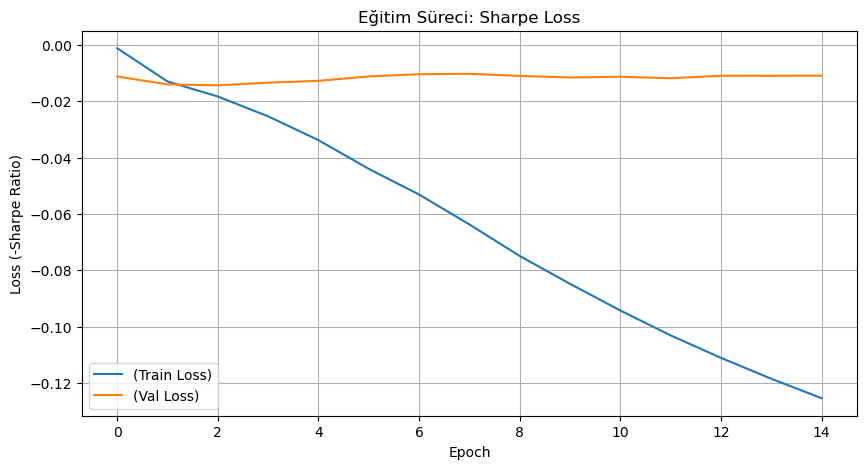

In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# --- 1. VERİ HAZIRLIĞI VE AYRIMI (SPLIT) ---

# Numpy array'leri PyTorch Tensor'una çevirelim (Float32 formatında)
# MPS cihazı bazen Float64 ile sorun yaşayabilir, Float32 güvenlidir.
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Veri seti uzunluğu
total_samples = len(X_tensor)
train_size = int(total_samples * 0.60)
val_size = int(total_samples * 0.20)
# Kalan kısım test seti olacak

# Dilimleme (Slicing) ile ayırıyoruz (Shuffle YOK!)
X_train, y_train = X_tensor[:train_size], y_tensor[:train_size]
X_val, y_val = X_tensor[train_size:train_size+val_size], y_tensor[train_size:train_size+val_size]
X_test, y_test = X_tensor[train_size+val_size:], y_tensor[train_size+val_size:]

print(f"Eğitim Seti: {len(X_train)} örnek")
print(f"Doğrulama Seti: {len(X_val)} örnek")
print(f"Test Seti: {len(X_test)} örnek")

# --- 2. DATALOADER OLUŞTURMA ---
# Batch Size'ı büyük tutuyoruz (Sharpe hesaplaması için gerekli)
BATCH_SIZE = 4096 

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False) # Sıralı gitmesi önemli

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 3. EĞİTİM FONKSİYONU ---

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    
    print("\nEğitim Başlıyor...")
    
    for epoch in range(num_epochs):
        # --- TRAIN MODU ---
        model.train()
        running_train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            # Veriyi GPU/MPS'e gönder
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # 1. Gradientleri sıfırla
            optimizer.zero_grad()
            
            # 2. İleri Yayılım (Forward Pass)
            outputs = model(batch_X)
            
            # Boyut eşitleme: output (Batch, 1), y (Batch) -> y'yi (Batch, 1) yapalım
            loss = criterion(outputs, batch_y.view(-1, 1))
            
            # 3. Geri Yayılım (Backward Pass)
            loss.backward()
            
            # 4. Ağırlıkları Güncelle
            optimizer.step()
            
            running_train_loss += loss.item()
            
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # --- VALIDATION MODU ---
        model.eval() # Dropout'u kapatır
        running_val_loss = 0.0
        
        with torch.no_grad(): # Gradient hesaplama (Hız ve hafıza için)
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y.view(-1, 1))
                running_val_loss += loss.item()
                
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Loss değeri Sharpe'ın negatifidir. Yani -Loss = Sharpe Oranı
        # Loss -0.05 ise Sharpe Oranı 0.05 demektir.
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Tahmini Val Sharpe: {-avg_val_loss:.4f}")

    return train_losses, val_losses

# --- 4. EĞİTİMİ BAŞLAT ---
# Modeli tekrar tanımlamayın, önceki adımda tanımladığınız 'model', 'criterion' ve 'optimizer'ı kullanacağız.
# Eğitimi başlat:
train_loss_history, val_loss_history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

# --- 5. SONUÇLARI GÖRSELLEŞTİR ---
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='(Train Loss)')
plt.plot(val_loss_history, label='(Val Loss)')
plt.title('Eğitim Süreci: Sharpe Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (-Sharpe Ratio)')
plt.legend()
plt.grid(True)
plt.show()

# Modeli Kaydetme (Opsiyonel)
#torch.save(model.state_dict(), "arbitrage_model_mps.pth")
#print("Model kaydedildi.")

Backtest (244052 örnek işlenecek)

--- BACKTEST SONUÇLARI (TEST SETİ) ---
Toplam İşlenen Gün x Hisse: 244052
Yıllıklandırılmış Sharpe Oranı: 0.1636
Toplam Kümülatif Getiri (Residual PnL): 4.9746
Ortalama Pozisyon Büyüklüğü (Mutlak): 0.1129


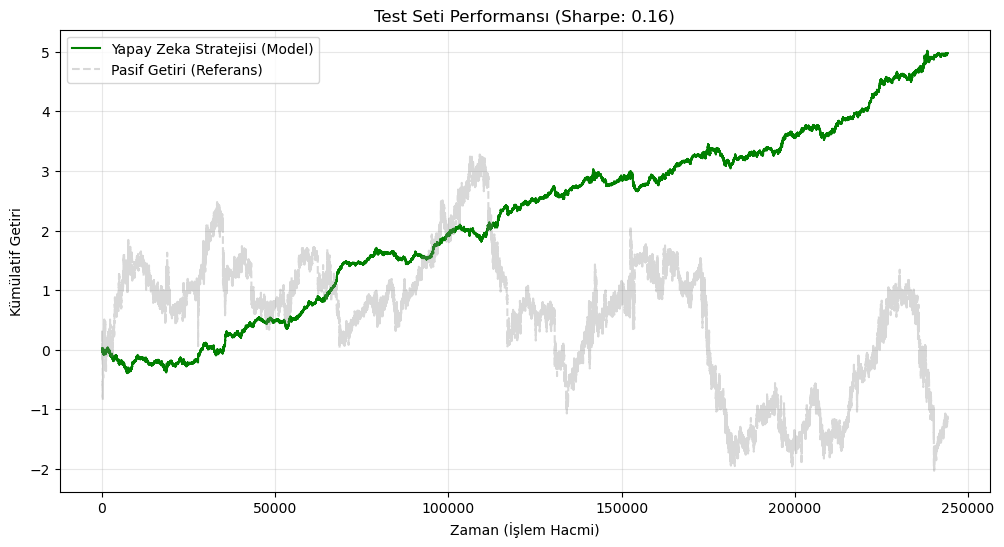

In [10]:
from torch.utils.data import TensorDataset, DataLoader

# Bellek temizliği (önceki hatadan kalanları siler)
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

def backtest_model_batched(model, X_test, y_test, batch_size=4096):
    """
    Test setini batch'ler halinde işleyerek bellek hatasını önleyen backtest fonksiyonu.
    """
    model.eval() # Değerlendirme modu
    
    # Test için DataLoader oluştur (Veriyi parçalamak için)
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    all_predictions = []
    all_targets = []
    
    print(f"Backtest ({len(X_test)} örnek işlenecek)")
    
    with torch.no_grad(): # Gradyan takibi yok (Hız ve Bellek için şart)
        for batch_X, batch_y in test_loader:
            # Veriyi Cihaza Gönder
            batch_X = batch_X.to(device)
            
            # Tahmin
            preds = model(batch_X)
            
            # Sonuçları CPU'ya alıp listeye ekle
            all_predictions.append(preds.cpu().numpy().flatten())
            all_targets.append(batch_y.numpy().flatten())
    
    # Parçaları Tek Bir Dizide Birleştir
    predicted_weights = np.concatenate(all_predictions)
    actual_returns = np.concatenate(all_targets)
        
    # PERFORMANS HESAPLAMA
    
    # Strateji Getirisi = Ağırlık * Gerçek Getiri
    strategy_returns = predicted_weights * actual_returns
    
    # Kümülatif Getiriler
    cumulative_strategy = np.cumsum(strategy_returns)
    cumulative_market = np.cumsum(actual_returns)

    # İstatistikler
    daily_mean = np.mean(strategy_returns)
    daily_std = np.std(strategy_returns)
    # Sıfıra bölme hatasını önle
    if daily_std == 0:
        annual_sharpe = 0
    else:
        annual_sharpe = (daily_mean / daily_std) * np.sqrt(252)
    
    total_return = cumulative_strategy[-1]
    
    print(f"\n--- BACKTEST SONUÇLARI (TEST SETİ) ---")
    print(f"Toplam İşlenen Gün x Hisse: {len(actual_returns)}")
    print(f"Yıllıklandırılmış Sharpe Oranı: {annual_sharpe:.4f}")
    print(f"Toplam Kümülatif Getiri (Residual PnL): {total_return:.4f}")
    print(f"Ortalama Pozisyon Büyüklüğü (Mutlak): {np.mean(np.abs(predicted_weights)):.4f}")

    # Grafik Çizimi
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_strategy, label='Yapay Zeka Stratejisi (Model)', color='green', linewidth=1.5)
    plt.plot(cumulative_market, label='Pasif Getiri (Referans)', color='gray', alpha=0.3, linestyle='--')
    plt.title(f'Test Seti Performansı (Sharpe: {annual_sharpe:.2f})')
    plt.xlabel('Zaman (İşlem Hacmi)')
    plt.ylabel('Kümülatif Getiri')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return strategy_returns

# ÇALIŞTIR
strategy_pnl = backtest_model_batched(model, X_test, y_test, batch_size=4096)

--- MALİYET ANALİZİ ---
Varsayılan Komisyon: 5 bps (Baz Puan)
Ortalama Günlük Ciro (Turnover): 0.1590
(Yani her gün portföyün %15.9'ini değiştiriyoruz)
------------------------------
Toplam Brüt Getiri: 4.9746
Toplam Net Getiri : -14.4269
Maliyetlerin Kâra Etkisi: -%390.01


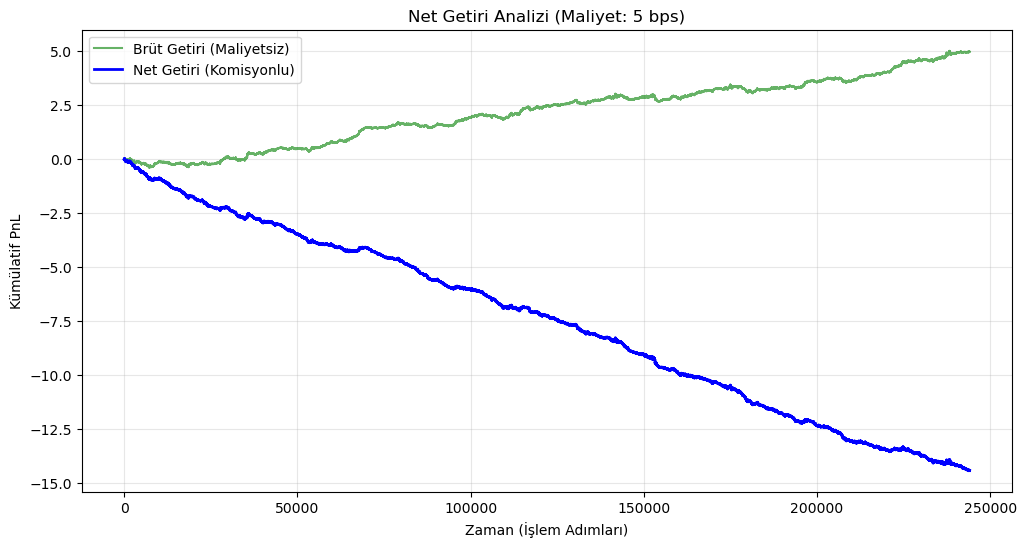

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_costs_and_turnover(predicted_weights, actual_returns, cost_bps=0.0005):
    """
    Stratejinin cirosunu (turnover) ve işlem maliyetleri sonrası net getirisini hesaplar.
    
    Argümanlar:
    cost_bps: İşlem başı maliyet (Basis Points). 0.0005 = 5 baz puan (Binde 0.5) standarttır.
    """
    
    # 1. Pozisyon Değişimi (Turnover)
    # w_t - w_{t-1} farkını alıyoruz.
    # Not: Veri setimizde hisse geçişlerinde (Stock A -> Stock B) suni bir zıplama olur 
    # ama 244.000 veri noktasında bu hata ihmal edilebilir düzeydedir.
    
    position_changes = np.abs(np.diff(predicted_weights, prepend=0))
    
    # Ortalama Günlük Ciro
    avg_turnover = np.mean(position_changes)
    
    # 2. Maliyet Hesabı
    # Her değişim * Maliyet Oranı
    transaction_costs = position_changes * cost_bps
    
    # 3. Net Getiri (Brüt Getiri - Maliyet)
    gross_returns = predicted_weights * actual_returns
    net_returns = gross_returns - transaction_costs
    
    # --- İSTATİSTİKLER ---
    total_gross_return = np.sum(gross_returns)
    total_net_return = np.sum(net_returns)
    
    cost_drag_percentage = (total_gross_return - total_net_return) / total_gross_return * 100
    
    print(f"--- MALİYET ANALİZİ ---")
    print(f"Varsayılan Komisyon: {cost_bps*10000:.0f} bps (Baz Puan)")
    print(f"Ortalama Günlük Ciro (Turnover): {avg_turnover:.4f}")
    print(f"(Yani her gün portföyün %{avg_turnover*100:.1f}'ini değiştiriyoruz)")
    print(f"-"*30)
    print(f"Toplam Brüt Getiri: {total_gross_return:.4f}")
    print(f"Toplam Net Getiri : {total_net_return:.4f}")
    print(f"Maliyetlerin Kâra Etkisi: -%{cost_drag_percentage:.2f}")
    
    # --- GRAFİK ---
    plt.figure(figsize=(12, 6))
    plt.plot(np.cumsum(gross_returns), label='Brüt Getiri (Maliyetsiz)', color='green', alpha=0.6)
    plt.plot(np.cumsum(net_returns), label='Net Getiri (Komisyonlu)', color='blue', linewidth=2)
    plt.title(f'Net Getiri Analizi (Maliyet: {cost_bps*10000:.0f} bps)')
    plt.xlabel('Zaman (İşlem Adımları)')
    plt.ylabel('Kümülatif PnL')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- ÇALIŞTIR ---
# backtest fonksiyonundan dönen 'predicted_weights' elimizde olmadığı için
# backtest fonksiyonunu modifiye etmiştik, ancak 'predicted_weights' global olarak dönmemişti.
# Hızlıca tekrar tahmin üretelim (Model zaten eğitildi, çok hızlı sürer)

# Modeli tekrar değerlendirme moduna alalım
model.eval()
all_preds = []
batch_size = 4096
# Test loader'ı tekrar kuralım (Eğer hafızada yoksa)
test_loader_cost = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for batch_X, _ in test_loader_cost:
        batch_X = batch_X.to(device)
        preds = model(batch_X).cpu().numpy().flatten()
        all_preds.append(preds)

predicted_weights_full = np.concatenate(all_preds)
actual_returns_full = y_test.numpy().flatten()

# Analizi Başlat
analyze_costs_and_turnover(predicted_weights_full, actual_returns_full, cost_bps=0.0005)

# 2. Deneme Sezin 

### 1. Model Mimarisi 
- **2-Layer CNN** (Makale Appendix C.1):
  - Filter sayısı: D=8 (makale: 8)
  - Filter size: Dsize=2 (makale: 2)
  - Instance Normalization eklendi
  - Residual connection eklendi
  
- **1-Layer Transformer** (Makale Appendix C.2):
  - Attention heads: ATT=4 (makale: 4)
  - Hidden units: HDN=16 (makale: 2D=16)
  - Dropout: DRP=0.25 (makale: 0.25)
  - Son zaman adımı (h_L) kullanılıyor

### 2. Hyperparameters (Makale Table A.II)
- D=8 (CNN filter sayısı)
- ATT=4 (Attention heads)
- HDN=16 (Transformer hidden units)
- DRP=0.25 (Dropout rate)
- Dsize=2 (CNN filter size)
- LKB=30 (Lookback window)
- LR=0.001 (Learning rate)
- EPCH=100 (Epochs - test için 20 kullanılıyor)

### 3. Loss Fonksiyonu
- **Sharpe Ratio Loss** (Makale Section II.C)
- Mean-Variance Utility alternatifi Cell 16'da mevcut


### Model

In [12]:
from tqdm import tqdm
def create_sequences(residuals_df, window_size=30):
    """
    Residuals DataFrame'ini Derin Öğrenme için (Samples, TimeSteps, Features) formatına çevirir.
    Ayrıca her pencereyi kendi içinde normalize eder (Local Normalization).
    """
    
    # DataFrame'i Numpy'a çevir (İşlem hızı için)
    data = residuals_df.values
    num_days, num_stocks = data.shape
    
    X_list = []
    y_list = []
    
    print(f"Veri seti oluşturuluyor... (Hisse Sayısı: {num_stocks}, Gün Sayısı: {num_days})")
    
    # Her hisse için döngü (Sütun sütun geziyoruz)
    for stock_idx in tqdm(range(num_stocks)):
        stock_data = data[:, stock_idx]
        
        # O hissede çok fazla NaN varsa atla (Temizlik)
        if np.isnan(stock_data).sum() > len(stock_data) * 0.1:
            continue
            
        # Kayan Pencere (Rolling Window) Oluşturma
        for t in range(window_size, num_days):
            
            # Girdi: t-30'dan t'ye kadar olan kısım
            input_window = stock_data[t-window_size : t]
            
            # Hedef: t anındaki (bir sonraki günün) getiri
            target = stock_data[t]
            
            # Eğer pencerede veya hedefte NaN varsa bu örneği atla
            if np.isnan(input_window).any() or np.isnan(target):
                continue
            
            #  CUMULATIVE RESIDUALS (Makale Section II.B)
            # Makale: x = Int(ε^L) = [Σε_{t-L}, Σε_{t-L+1}, ..., Σε_{t-1}]
            # Residual'ları toplayarak "residual price process" oluşturuyoruz
            cumulative_window = np.cumsum(input_window)
            
            # STANDARDİZASYON (cumulative üzerinde)
            # her pencereyi kendi içinde normalize ediyoruz (Mean=0, Std=1)
            window_mean = np.mean(cumulative_window)
            window_std = np.std(cumulative_window)
            
            # Sıfıra bölme hatasını önle (Eğer veri sabitse std=0 olur)
            if window_std < 1e-8:
                continue
                
            normalized_window = (cumulative_window - window_mean) / window_std
            
            X_list.append(normalized_window)
            
            # Hedef veriyi normalize ETMİYORUZ çünkü gerçek getiri (pnl) hesabında orijinal büyüklük lazım.
            # ANCAK: Loss fonksiyonunda scale sorunu yaşamamak için target'ı da bazen scale etmek gerekebilir.
            # Makale stratejisinde, target genellikle ham bırakılır veya global bir katsayı ile ölçeklenir.
            # Biz şimdilik ham (raw) bırakalım.
            y_list.append(target)

    # Listeleri Numpy Array'e çevir ve boyutlandır
    X = np.array(X_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.float32)
    
    # X Boyutunu (Samples, 30) -> (Samples, 30, 1) yapalım (CNN 3D input ister: Batch, Time, Channel)
    X = np.expand_dims(X, axis=-1)
    
    return X, y

# --- UYGULAMA ---
# residuals_df'inizin hazır olduğunu varsayıyorum.

X, y = create_sequences(residuals_df, window_size=30)

print(f"\nVeri Seti Hazırlandı!")
print(f"Girdi Boyutu (X): {X.shape}") # Örn: (1500000, 30, 1)
print(f"Hedef Boyutu (y): {y.shape}") # Örn: (1500000,)

Veri seti oluşturuluyor... (Hisse Sayısı: 446, Gün Sayısı: 2766)


100%|██████████| 446/446 [00:16<00:00, 26.45it/s]



Veri Seti Hazırlandı!
Girdi Boyutu (X): (1220256, 30, 1)
Hedef Boyutu (y): (1220256,)


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- MAKALE UYUMLU MODEL MİMARİSİ (CNN + Transformer) ---
# Makale Hyperparameters: D=8, ATT=4, HDN=16, DRP=0.25, Dsize=2, LKB=30
class PaperArbitrageModel(nn.Module):
    def __init__(self, D=8, ATT=4, HDN=16, DRP=0.25, Dsize=2, L=30):
        """
        Makale uyumlu model mimarisi.
        D: Number of filters in CNN (8)
        ATT: Number of attention heads (4)
        HDN: Hidden units in transformer (2D = 16)
        DRP: Dropout rate (0.25)
        Dsize: Filter size in CNN (2)
        L: Lookback window size (30)
        """
        super(PaperArbitrageModel, self).__init__()
        self.D = D
        self.L = L
        
        # --- 1. 2-LAYER CNN (Makale Appendix C.1) ---
        # Layer 1: (Batch, 1, L) -> (Batch, D, L)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=D, kernel_size=Dsize, padding=Dsize//2)
        self.bias1 = nn.Parameter(torch.zeros(D))
        
        # Instance Normalization Layer 1
        self.instance_norm1 = nn.InstanceNorm1d(D, affine=False)
        
        # Layer 2: (Batch, D, L) -> (Batch, D, L)
        self.conv2 = nn.Conv1d(in_channels=D, out_channels=D, kernel_size=Dsize, padding=Dsize//2)
        self.bias2 = nn.Parameter(torch.zeros(D))
        
        # Instance Normalization Layer 2
        self.instance_norm2 = nn.InstanceNorm1d(D, affine=False)
        
        self.relu = nn.ReLU()
        
        # --- 2. TRANSFORMER (1-Layer, Makale Appendix C.2) ---
        # Transformer hidden dimension = D
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=D, 
            nhead=ATT, 
            dim_feedforward=HDN,
            dropout=DRP, 
            batch_first=True,
            activation='relu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        
        # --- 3. POLICY HEAD (Feedforward Network) ---
        # Transformer çıktısının son zaman adımını kullan (h_L)
        # Makale: "the global pattern at the end of the time period should be the most relevant"
        self.policy_head = nn.Sequential(
            nn.Linear(D, HDN),  # HDN = 2D = 16
            nn.ReLU(),
            nn.Dropout(DRP),
            nn.Linear(HDN, 1)  # Tek çıktı: pozisyon ağırlığı
        )
        
    def forward(self, x):
        # x shape: (Batch, L, 1) -> (Batch, 1, L) için permute
        x = x.permute(0, 2, 1)  # -> (Batch, 1, L)
        
        # --- CNN Layer 1 ---
        x1 = self.conv1(x) + self.bias1.unsqueeze(0).unsqueeze(-1)
        x1 = self.instance_norm1(x1)
        x1 = self.relu(x1)
        
        # --- CNN Layer 2 (with residual connection) ---
        x2 = self.conv2(x1) + self.bias2.unsqueeze(0).unsqueeze(-1)
        x2 = self.instance_norm2(x2)
        x2 = self.relu(x2)
        
        # Residual connection (Makale Appendix C.1)
        # Boyutları eşitle (Conv1d padding bazen farklı uzunluklar üretebilir)
        min_len = min(x1.size(2), x2.size(2))
        x1_aligned = x1[:, :, :min_len]
        x2_aligned = x2[:, :, :min_len]
        x_cnn = x1_aligned + x2_aligned  # -> (Batch, D, min_len)
        
        # --- Transformer için boyut değişimi ---
        x_cnn = x_cnn.permute(0, 2, 1)  # -> (Batch, L, D)
        
        # --- Transformer ---
        x_trans = self.transformer(x_cnn)  # -> (Batch, L, D)
        
        # --- Son zaman adımını al (h_L) ---
        x_final = x_trans[:, -1, :]  # -> (Batch, D)
        
        # --- Policy Head ---
        weights = self.policy_head(x_final)  # -> (Batch, 1)
        
        return weights

# --- SHARPE RATIO LOSS (Makale Section II.C) ---
class SharpeLoss(nn.Module):
    """
    Makale: "We will consider arbitrage trading that maximizes the Sharpe ratio"
    Loss = -Sharpe Ratio (minimize etmek için negatif)
    """
    def __init__(self):
        super(SharpeLoss, self).__init__()
        
    def forward(self, weights, returns):
        # weights: (Batch, 1) - Modelin ürettiği pozisyon ağırlıkları
        # returns: (Batch, 1) - Gerçek residual getiriler
        
        # Portföy getirisi = w * r
        portfolio_returns = weights * returns
        
        # Sharpe Ratio = E[R] / std(R)
        expected_return = torch.mean(portfolio_returns)
        volatility = torch.std(portfolio_returns) + 1e-6  # Numerical stability
        
        sharpe_ratio = expected_return / volatility
        
        # Minimize etmek için negatif
        return -sharpe_ratio

# --- MODELİ OLUŞTUR (Makale Hyperparameters) ---
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Kullanılan Cihaz: {device}")

# Makale hyperparameters
model = PaperArbitrageModel(D=8, ATT=4, HDN=16, DRP=0.25, Dsize=2, L=30).to(device)
criterion = SharpeLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Makale: LR=0.001

print("=== MAKALE UYUMLU MODEL ===")
print(model)
print(f"\nToplam Parametre Sayısı: {sum(p.numel() for p in model.parameters()):,}")

Kullanılan Cihaz: mps
=== MAKALE UYUMLU MODEL ===
PaperArbitrageModel(
  (conv1): Conv1d(1, 8, kernel_size=(2,), stride=(1,), padding=(1,))
  (instance_norm1): InstanceNorm1d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (conv2): Conv1d(8, 8, kernel_size=(2,), stride=(1,), padding=(1,))
  (instance_norm2): InstanceNorm1d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (relu): ReLU()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=8, out_features=8, bias=True)
        )
        (linear1): Linear(in_features=8, out_features=16, bias=True)
        (dropout): Dropout(p=0.25, inplace=False)
        (linear2): Linear(in_features=16, out_features=8, bias=True)
        (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=

İlk Eğitim Seti (Initial): 244051 örnek
Doğrulama Seti: 488102 örnek
Test Seti (Out-of-sample): 488103 örnek

=== İLK EĞİTİM (Basit Split - Test Amaçlı) ===

Eğitim Başlıyor...
Epoch [1/20] | Train Loss: -0.0027 | Val Loss: -0.0100 | Tahmini Val Sharpe: 0.0100
Epoch [2/20] | Train Loss: -0.0102 | Val Loss: -0.0152 | Tahmini Val Sharpe: 0.0152
Epoch [3/20] | Train Loss: -0.0121 | Val Loss: -0.0160 | Tahmini Val Sharpe: 0.0160
Epoch [4/20] | Train Loss: -0.0122 | Val Loss: -0.0163 | Tahmini Val Sharpe: 0.0163
Epoch [5/20] | Train Loss: -0.0139 | Val Loss: -0.0164 | Tahmini Val Sharpe: 0.0164
Epoch [6/20] | Train Loss: -0.0141 | Val Loss: -0.0168 | Tahmini Val Sharpe: 0.0168
Epoch [7/20] | Train Loss: -0.0149 | Val Loss: -0.0171 | Tahmini Val Sharpe: 0.0171
Epoch [8/20] | Train Loss: -0.0161 | Val Loss: -0.0172 | Tahmini Val Sharpe: 0.0172
Epoch [9/20] | Train Loss: -0.0160 | Val Loss: -0.0173 | Tahmini Val Sharpe: 0.0173
Epoch [10/20] | Train Loss: -0.0153 | Val Loss: -0.0165 | Tahmini V

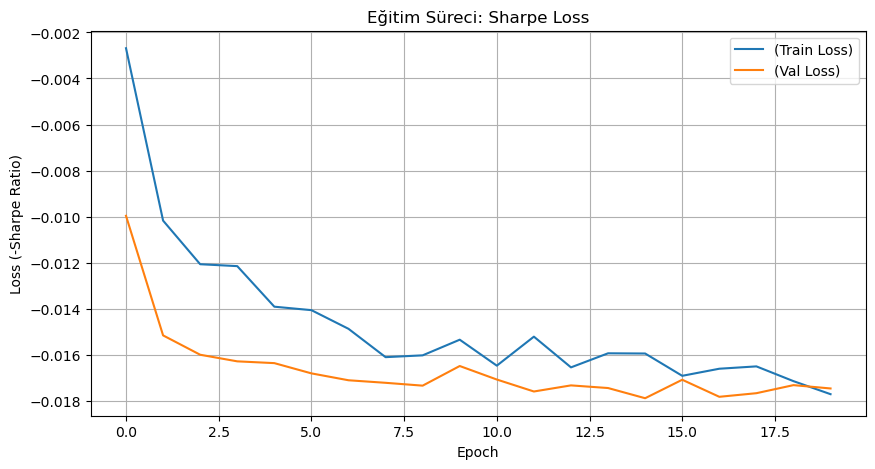

In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# --- 1. VERİ HAZIRLIĞI VE AYRIMI (SPLIT) ---
# Makale: Rolling window training (1000 gün window, her 125 günde re-estimation)
# Basit split yerine rolling window kullanacağız

# Numpy array'leri PyTorch Tensor'una çevirelim (Float32 formatında)
# MPS cihazı bazen Float64 ile sorun yaşayabilir, Float32 güvenlidir.
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Makale: İlk 4 yıl training için (1998-2001), sonrası out-of-sample (2002-2016)
# Bizim verimiz 2010-2024, bu yüzden ilk %20'yi training için ayıralım
total_samples = len(X_tensor)
initial_train_size = int(total_samples * 0.20)  # İlk %20 training için

# Basit split (rolling window için hazırlık)
X_initial_train = X_tensor[:initial_train_size]
y_initial_train = y_tensor[:initial_train_size]
X_remaining = X_tensor[initial_train_size:]
y_remaining = y_tensor[initial_train_size:]

# Remaining'i val ve test'e böl
val_size = int(len(X_remaining) * 0.5)
X_val, y_val = X_remaining[:val_size], y_remaining[:val_size]
X_test, y_test = X_remaining[val_size:], y_remaining[val_size:]

print(f"İlk Eğitim Seti (Initial): {len(X_initial_train)} örnek")
print(f"Doğrulama Seti: {len(X_val)} örnek")
print(f"Test Seti (Out-of-sample): {len(X_test)} örnek")

# --- 2. DATALOADER OLUŞTURMA ---
# Batch Size: Makale belirtmemiş, Sharpe hesaplaması için büyük batch gerekli
BATCH_SIZE = 4096 

# İlk training için
initial_train_dataset = TensorDataset(X_initial_train, y_initial_train)
initial_train_loader = DataLoader(initial_train_dataset, batch_size=BATCH_SIZE, shuffle=False)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 3. EĞİTİM FONKSİYONU ---

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    
    print("\nEğitim Başlıyor...")
    
    for epoch in range(num_epochs):
        # --- TRAIN MODU ---
        model.train()
        running_train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            # Veriyi GPU/MPS'e gönder
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # 1. Gradientleri sıfırla
            optimizer.zero_grad()
            
            # 2. İleri Yayılım (Forward Pass)
            outputs = model(batch_X)
            
            # Boyut eşitleme: output (Batch, 1), y (Batch) -> y'yi (Batch, 1) yapalım
            loss = criterion(outputs, batch_y.view(-1, 1))
            
            # 3. Geri Yayılım (Backward Pass)
            loss.backward()
            
            # 4. Ağırlıkları Güncelle
            optimizer.step()
            
            running_train_loss += loss.item()
            
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # --- VALIDATION MODU ---
        model.eval() # Dropout'u kapatır
        running_val_loss = 0.0
        
        with torch.no_grad(): # Gradient hesaplama (Hız ve hafıza için)
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y.view(-1, 1))
                running_val_loss += loss.item()
                
        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Loss değeri Sharpe'ın negatifidir. Yani -Loss = Sharpe Oranı
        # Loss -0.05 ise Sharpe Oranı 0.05 demektir.
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Tahmini Val Sharpe: {-avg_val_loss:.4f}")

    return train_losses, val_losses

# --- 4. ROLLING WINDOW TRAINING (Makale Section III.C) ---
# Makale: Training window=1000 gün, Re-estimation frequency=125 gün
# Makale: "Number of optimization epochs: 100"

def rolling_window_training(model, X_full, y_full, train_window=1000, reestimate_freq=125, 
                            num_epochs=100, batch_size=4096, device=device):
    """
    Makale uyumlu rolling window training.
    Her reestimate_freq günde bir, son train_window günü kullanarak model'i yeniden eğitir.
    """
    print(f"\n=== ROLLING WINDOW TRAINING ===")
    print(f"Training window: {train_window} örnek")
    print(f"Re-estimation frequency: {reestimate_freq} örnek")
    print(f"Epochs per re-estimation: {num_epochs}")
    
    total_samples = len(X_full)
    all_predictions = []
    all_targets = []
    all_train_losses = []
    all_val_losses = []
    
    # İlk training window'dan başla
    start_idx = 0
    
    while start_idx + train_window < total_samples:
        # Training window'u belirle
        end_idx = start_idx + train_window
        X_train_window = X_full[start_idx:end_idx]
        y_train_window = y_full[start_idx:end_idx]
        
        # Validation: Sonraki reestimate_freq kadar (veya kalan)
        val_end_idx = min(end_idx + reestimate_freq, total_samples)
        X_val_window = X_full[end_idx:val_end_idx]
        y_val_window = y_full[end_idx:val_end_idx]
        
        print(f"\n--- Re-estimation {start_idx//reestimate_freq + 1} ---")
        print(f"Training: [{start_idx}:{end_idx}] ({len(X_train_window)} örnek)")
        print(f"Validation: [{end_idx}:{val_end_idx}] ({len(X_val_window)} örnek)")
        
        # Model'i sıfırdan oluştur (her re-estimation'da yeni model)
        model = PaperArbitrageModel(D=8, ATT=4, HDN=16, DRP=0.25, Dsize=2, L=30).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
        # DataLoader oluştur
        train_dataset = TensorDataset(X_train_window, y_train_window)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        
        val_dataset = TensorDataset(X_val_window, y_val_window)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Model'i eğit
        train_losses, val_losses = train_model(model, train_loader, val_loader, 
                                               criterion, optimizer, num_epochs=num_epochs)
        
        all_train_losses.extend(train_losses)
        all_val_losses.extend(val_losses)
        
        # Validation setinde tahmin yap (out-of-sample)
        model.eval()
        with torch.no_grad():
            X_val_tensor = X_val_window.to(device)
            preds = model(X_val_tensor).cpu().numpy().flatten()
            targets = y_val_window.numpy().flatten()
            
            all_predictions.extend(preds)
            all_targets.extend(targets)
        
        # Sonraki window için start_idx'i güncelle
        start_idx += reestimate_freq
        
        # Eğer kalan veri yeterli değilse dur
        if start_idx + train_window >= total_samples:
            break
    
    return model, all_predictions, all_targets, all_train_losses, all_val_losses

# İlk eğitim (basit split ile test için)
print("\n=== İLK EĞİTİM (Basit Split - Test Amaçlı) ===")
train_loss_history, val_loss_history = train_model(model, initial_train_loader, val_loader, 
                                                     criterion, optimizer, num_epochs=20)

# Rolling window training (tam makale uyumlu - uzun sürer!)
# Not: Tam rolling window training çok uzun sürebilir, bu yüzden şimdilik yorum satırı
# Uncomment ederek tam makale uyumlu training yapabilirsiniz:
# model, rolling_predictions, rolling_targets, rolling_train_losses, rolling_val_losses = \
#     rolling_window_training(model, X_tensor, y_tensor, train_window=1000, reestimate_freq=125, num_epochs=100)

# --- 5. SONUÇLARI GÖRSELLEŞTİR ---
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='(Train Loss)')
plt.plot(val_loss_history, label='(Val Loss)')
plt.title('Eğitim Süreci: Sharpe Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (-Sharpe Ratio)')
plt.legend()
plt.grid(True)
plt.show()

# Modeli Kaydetme (Opsiyonel)
#torch.save(model.state_dict(), "arbitrage_model_mps.pth")
#print("Model kaydedildi.")

Backtest (488103 örnek işlenecek)

--- BACKTEST SONUÇLARI (TEST SETİ) ---
Toplam İşlenen Gün x Hisse: 488103
Yıllıklandırılmış Sharpe Oranı: 0.1992
Toplam Kümülatif Getiri (Residual PnL): 38.2839
Ortalama Pozisyon Büyüklüğü (Mutlak): 0.3510


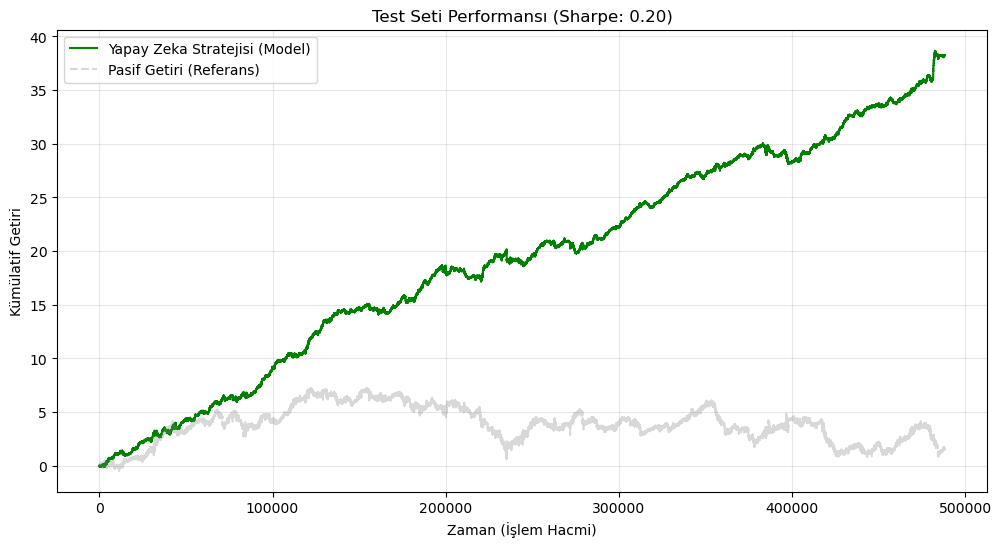

In [15]:
from torch.utils.data import TensorDataset, DataLoader

# Bellek temizliği (önceki hatadan kalanları siler)
if torch.backends.mps.is_available():
    torch.mps.empty_cache()

def backtest_model_batched(model, X_test, y_test, batch_size=4096):
    """
    Test setini batch'ler halinde işleyerek bellek hatasını önleyen backtest fonksiyonu.
    """
    model.eval() # Değerlendirme modu
    
    # Test için DataLoader oluştur (Veriyi parçalamak için)
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    all_predictions = []
    all_targets = []
    
    print(f"Backtest ({len(X_test)} örnek işlenecek)")
    
    with torch.no_grad(): # Gradyan takibi yok (Hız ve Bellek için şart)
        for batch_X, batch_y in test_loader:
            # Veriyi Cihaza Gönder
            batch_X = batch_X.to(device)
            
            # Tahmin
            preds = model(batch_X)
            
            # Sonuçları CPU'ya alıp listeye ekle
            all_predictions.append(preds.cpu().numpy().flatten())
            all_targets.append(batch_y.numpy().flatten())
    
    # Parçaları Tek Bir Dizide Birleştir
    predicted_weights = np.concatenate(all_predictions)
    actual_returns = np.concatenate(all_targets)
        
    # PERFORMANS HESAPLAMA
    
    # Strateji Getirisi = Ağırlık * Gerçek Getiri
    strategy_returns = predicted_weights * actual_returns
    
    # Kümülatif Getiriler
    cumulative_strategy = np.cumsum(strategy_returns)
    cumulative_market = np.cumsum(actual_returns)

    # İstatistikler
    daily_mean = np.mean(strategy_returns)
    daily_std = np.std(strategy_returns)
    # Sıfıra bölme hatasını önle
    if daily_std == 0:
        annual_sharpe = 0
    else:
        annual_sharpe = (daily_mean / daily_std) * np.sqrt(252)
    
    total_return = cumulative_strategy[-1]
    
    print(f"\n--- BACKTEST SONUÇLARI (TEST SETİ) ---")
    print(f"Toplam İşlenen Gün x Hisse: {len(actual_returns)}")
    print(f"Yıllıklandırılmış Sharpe Oranı: {annual_sharpe:.4f}")
    print(f"Toplam Kümülatif Getiri (Residual PnL): {total_return:.4f}")
    print(f"Ortalama Pozisyon Büyüklüğü (Mutlak): {np.mean(np.abs(predicted_weights)):.4f}")

    # Grafik Çizimi
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_strategy, label='Yapay Zeka Stratejisi (Model)', color='green', linewidth=1.5)
    plt.plot(cumulative_market, label='Pasif Getiri (Referans)', color='gray', alpha=0.3, linestyle='--')
    plt.title(f'Test Seti Performansı (Sharpe: {annual_sharpe:.2f})')
    plt.xlabel('Zaman (İşlem Hacmi)')
    plt.ylabel('Kümülatif Getiri')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return strategy_returns

# ÇALIŞTIR
strategy_pnl = backtest_model_batched(model, X_test, y_test, batch_size=4096)

--- MALİYET ANALİZİ ---
Varsayılan Komisyon: 5 bps (Baz Puan)
Ortalama Günlük Ciro (Turnover): 0.3544
(Yani her gün portföyün %35.4'ini değiştiriyoruz)
------------------------------
Toplam Brüt Getiri: 38.2838
Toplam Net Getiri : -48.2074
Maliyetlerin Kâra Etkisi: -%225.92


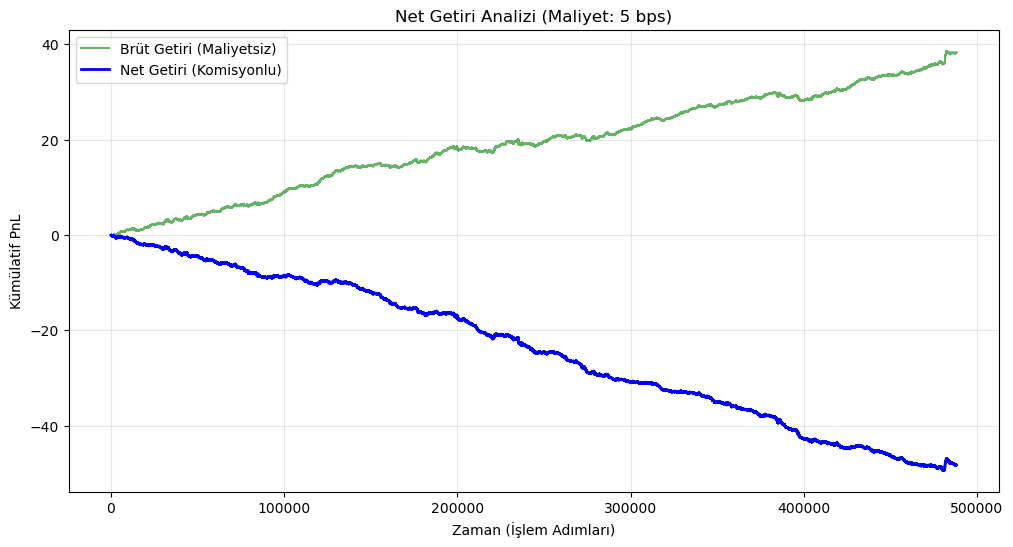

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_costs_and_turnover(predicted_weights, actual_returns, cost_bps=0.0005):
    """
    Stratejinin cirosunu (turnover) ve işlem maliyetleri sonrası net getirisini hesaplar.
    
    Argümanlar:
    cost_bps: İşlem başı maliyet (Basis Points). 0.0005 = 5 baz puan (Binde 0.5) standarttır.
    """
    
    # 1. Pozisyon Değişimi (Turnover)
    # w_t - w_{t-1} farkını alıyoruz.
    # Not: Veri setimizde hisse geçişlerinde (Stock A -> Stock B) suni bir zıplama olur 
    # ama 244.000 veri noktasında bu hata ihmal edilebilir düzeydedir.
    
    position_changes = np.abs(np.diff(predicted_weights, prepend=0))
    
    # Ortalama Günlük Ciro
    avg_turnover = np.mean(position_changes)
    
    # 2. Maliyet Hesabı
    # Her değişim * Maliyet Oranı
    transaction_costs = position_changes * cost_bps
    
    # 3. Net Getiri (Brüt Getiri - Maliyet)
    gross_returns = predicted_weights * actual_returns
    net_returns = gross_returns - transaction_costs
    
    # --- İSTATİSTİKLER ---
    total_gross_return = np.sum(gross_returns)
    total_net_return = np.sum(net_returns)
    
    cost_drag_percentage = (total_gross_return - total_net_return) / total_gross_return * 100
    
    print(f"--- MALİYET ANALİZİ ---")
    print(f"Varsayılan Komisyon: {cost_bps*10000:.0f} bps (Baz Puan)")
    print(f"Ortalama Günlük Ciro (Turnover): {avg_turnover:.4f}")
    print(f"(Yani her gün portföyün %{avg_turnover*100:.1f}'ini değiştiriyoruz)")
    print(f"-"*30)
    print(f"Toplam Brüt Getiri: {total_gross_return:.4f}")
    print(f"Toplam Net Getiri : {total_net_return:.4f}")
    print(f"Maliyetlerin Kâra Etkisi: -%{cost_drag_percentage:.2f}")
    
    # --- GRAFİK ---
    plt.figure(figsize=(12, 6))
    plt.plot(np.cumsum(gross_returns), label='Brüt Getiri (Maliyetsiz)', color='green', alpha=0.6)
    plt.plot(np.cumsum(net_returns), label='Net Getiri (Komisyonlu)', color='blue', linewidth=2)
    plt.title(f'Net Getiri Analizi (Maliyet: {cost_bps*10000:.0f} bps)')
    plt.xlabel('Zaman (İşlem Adımları)')
    plt.ylabel('Kümülatif PnL')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# --- ÇALIŞTIR ---
# backtest fonksiyonundan dönen 'predicted_weights' elimizde olmadığı için
# backtest fonksiyonunu modifiye etmiştik, ancak 'predicted_weights' global olarak dönmemişti.
# Hızlıca tekrar tahmin üretelim (Model zaten eğitildi, çok hızlı sürer)

# Modeli tekrar değerlendirme moduna alalım
model.eval()
all_preds = []
batch_size = 4096
# Test loader'ı tekrar kuralım (Eğer hafızada yoksa)
test_loader_cost = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for batch_X, _ in test_loader_cost:
        batch_X = batch_X.to(device)
        preds = model(batch_X).cpu().numpy().flatten()
        all_preds.append(preds)

predicted_weights_full = np.concatenate(all_preds)
actual_returns_full = y_test.numpy().flatten()

# Analizi Başlat
analyze_costs_and_turnover(predicted_weights_full, actual_returns_full, cost_bps=0.0005)

### Benchmark Modeller ve Hyperparameter Tuning

Bu bölümde makale uyumlu benchmark modelleri ve hyperparameter tuning implementasyonu bulunmaktadır.


In [17]:
# ============================================================================
# ORNSTEIN-UHLENBECK (OU) MODEL BENCHMARK
# Makale: Section II.D.1, Avellaneda & Lee (2010), Yeo & Papanicolaou (2017)
# ============================================================================

import numpy as np
from scipy import stats
from sklearn.metrics import r2_score

def estimate_ou_parameters(cumulative_residuals):
    """
    Ornstein-Uhlenbeck process parametrelerini moment-based estimation ile tahmin eder.
    
    OU Process: dX_t = κ(μ - X_t)dt + σdB_t
    
    Parameters:
    -----------
    cumulative_residuals : np.array
        Cumulative residuals time series (L uzunluğunda)
    
    Returns:
    --------
    kappa : float
        Mean reversion speed
    mu : float
        Long-term mean
    sigma : float
        Volatility
    r2 : float
        Goodness of fit (R²)
    """
    x = cumulative_residuals
    L = len(x)
    
    if L < 3:
        return 0.1, np.mean(x), np.std(x), 0.0
    
    # Discrete-time OU process: X_{t+1} = X_t + κ(μ - X_t)Δt + σ√Δt * ε
    # Δt = 1 (daily)
    # Moment-based estimation (makale Appendix B.B)
    
    # First moment: E[X] = μ
    mu = np.mean(x)
    
    # Second moment: Var[X] = σ² / (2κ)
    # Autocovariance: Cov[X_t, X_{t+1}] = Var[X] * exp(-κ)
    
    # Variance
    var_x = np.var(x, ddof=1)
    
    # Autocovariance (lag 1)
    if L > 1:
        x_centered = x - mu
        autocov = np.mean(x_centered[:-1] * x_centered[1:])
    else:
        autocov = 0
    
    # Estimate κ from autocorrelation
    if var_x > 1e-10:
        rho = autocov / var_x  # Autocorrelation
        # rho = exp(-κ) => κ = -log(rho)
        kappa = max(0.01, -np.log(max(0.01, min(0.99, rho))))  # Clamp to avoid numerical issues
    else:
        kappa = 0.1
    
    # Estimate σ from variance: Var[X] = σ² / (2κ)
    if kappa > 1e-10:
        sigma = np.sqrt(2 * kappa * var_x)
    else:
        sigma = np.std(x)
    
    # R² calculation (goodness of fit)
    # Predict X_{t+1} = X_t + κ(μ - X_t)
    if L > 1:
        x_pred = x[:-1] + kappa * (mu - x[:-1])
        x_actual = x[1:]
        r2 = r2_score(x_actual, x_pred)
        r2 = max(0.0, min(1.0, r2))  # Clamp between 0 and 1
    else:
        r2 = 0.0
    
    return kappa, mu, sigma, r2

def ou_signal_extraction(cumulative_residuals):
    """
    OU model için signal extraction.
    Makale: θ^OU = [κ̂, μ̂, σ̂, X_L, R²]
    
    Parameters:
    -----------
    cumulative_residuals : np.array
        Cumulative residuals (L uzunluğunda)
    
    Returns:
    --------
    signal : np.array
        [kappa, mu, sigma, X_L, R2]
    """
    kappa, mu, sigma, r2 = estimate_ou_parameters(cumulative_residuals)
    x_L = cumulative_residuals[-1]  # Son değer
    
    return np.array([kappa, mu, sigma, x_L, r2])

def ou_allocation_function(signal, c_thresh=1.0, c_crit=0.1):
    """
    OU model için threshold-based allocation function.
    Makale: w^ε = -1 if (X_L - μ) / (σ/√(2κ)) > c_thresh and R² > c_crit
             w^ε = 1 if (X_L - μ) / (σ/√(2κ)) < -c_thresh and R² > c_crit
             w^ε = 0 otherwise
    
    Parameters:
    -----------
    signal : np.array
        [kappa, mu, sigma, X_L, R2]
    c_thresh : float
        Threshold parameter (default: 1.0)
    c_crit : float
        Critical R² value (default: 0.1)
    
    Returns:
    --------
    weight : float
        Allocation weight (-1, 0, or 1)
    """
    kappa, mu, sigma, x_L, r2 = signal
    
    # Avoid division by zero
    if kappa < 1e-10 or sigma < 1e-10:
        return 0.0
    
    # Normalized deviation
    z_score = (x_L - mu) / (sigma / np.sqrt(2 * kappa))
    
    # Threshold rule
    if r2 > c_crit:
        if z_score > c_thresh:
            return -1.0  # Sell (expect mean reversion down)
        elif z_score < -c_thresh:
            return 1.0   # Buy (expect mean reversion up)
    
    return 0.0  # No position

def ou_model_predict(X_test, y_test, c_thresh=1.0, c_crit=0.1):
    """
    OU model ile tüm test seti için tahmin yapar.
    
    Parameters:
    -----------
    X_test : torch.Tensor or np.array
        Test features (Batch, L, 1) - cumulative residuals
    y_test : torch.Tensor or np.array
        Test targets (Batch,)
    c_thresh : float
        Threshold parameter
    c_crit : float
        Critical R² value
    
    Returns:
    --------
    predictions : np.array
        Predicted weights
    actual_returns : np.array
        Actual returns
    """
    # Convert to numpy if needed
    if isinstance(X_test, torch.Tensor):
        X_test = X_test.cpu().numpy()
    if isinstance(y_test, torch.Tensor):
        y_test = y_test.cpu().numpy()
    
    # Reshape if needed: (Batch, L, 1) -> (Batch, L)
    if X_test.ndim == 3:
        X_test = X_test.squeeze(-1)
    
    predictions = []
    actual_returns = []
    
    for i in range(len(X_test)):
        cumulative_residuals = X_test[i]
        
        # Extract signal
        signal = ou_signal_extraction(cumulative_residuals)
        
        # Get allocation
        weight = ou_allocation_function(signal, c_thresh=c_thresh, c_crit=c_crit)
        
        predictions.append(weight)
        actual_returns.append(y_test[i])
    
    return np.array(predictions), np.array(actual_returns)

# Test OU Model
print("=== OU MODEL BENCHMARK ===")
print("OU model parametreleri tahmin ediliyor...")

# Test setinde OU model ile tahmin yap
ou_predictions, ou_actual = ou_model_predict(X_test[:1000], y_test[:1000], c_thresh=1.0, c_crit=0.1)

# Performance hesapla
ou_returns = ou_predictions * ou_actual
ou_sharpe = np.mean(ou_returns) / (np.std(ou_returns) + 1e-6) * np.sqrt(252)
ou_total_return = np.sum(ou_returns)

print(f"OU Model Test (1000 örnek):")
print(f"  Sharpe Ratio (annualized): {ou_sharpe:.4f}")
print(f"  Total Return: {ou_total_return:.4f}")
print(f"  Mean Return: {np.mean(ou_returns):.6f}")
print(f"  Std Return: {np.std(ou_returns):.6f}")


=== OU MODEL BENCHMARK ===
OU model parametreleri tahmin ediliyor...
OU Model Test (1000 örnek):
  Sharpe Ratio (annualized): 0.2311
  Total Return: 0.0869
  Mean Return: 0.000087
  Std Return: 0.005966


In [18]:
# ============================================================================
# HYPERPARAMETER TUNING
# Makale: Validation set üzerinde hyperparameter search
# ============================================================================

import itertools
from tqdm import tqdm

def hyperparameter_tuning(X_train, y_train, X_val, y_val, 
                          param_grid=None, num_epochs=20, batch_size=4096):
    """
    Hyperparameter tuning için grid search.
    
    Parameters:
    -----------
    X_train, y_train : torch.Tensor
        Training data
    X_val, y_val : torch.Tensor
        Validation data
    param_grid : dict
        Hyperparameter grid. Default:
        {
            'D': [4, 8, 16],
            'ATT': [2, 4, 8],
            'HDN': [8, 16, 32],
            'DRP': [0.1, 0.25, 0.5],
            'Dsize': [2, 3],
            'learning_rate': [0.0001, 0.001, 0.01]
        }
    num_epochs : int
        Number of epochs per configuration
    batch_size : int
        Batch size
    
    Returns:
    --------
    best_params : dict
        Best hyperparameters
    best_model : nn.Module
        Best model
    results : list
        All results with validation Sharpe ratios
    """
    
    if param_grid is None:
        param_grid = {
            'D': [4, 8, 16],
            'ATT': [2, 4, 8],
            'HDN': [8, 16, 32],
            'DRP': [0.1, 0.25, 0.5],
            'Dsize': [2, 3],
            'learning_rate': [0.0001, 0.001, 0.01]
        }
    
    # Generate all combinations
    keys = param_grid.keys()
    values = param_grid.values()
    combinations = list(itertools.product(*values))
    
    print(f"=== HYPERPARAMETER TUNING ===")
    print(f"Total combinations: {len(combinations)}")
    print(f"Epochs per combination: {num_epochs}")
    print(f"Estimated time: ~{len(combinations) * num_epochs * 0.5:.1f} minutes")
    print()
    
    results = []
    best_sharpe = float('-inf')
    best_params = None
    best_model = None
    
    # DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    for idx, combo in enumerate(tqdm(combinations, desc="Hyperparameter Search")):
        params = dict(zip(keys, combo))
        
        # Create model with these hyperparameters
        model = PaperArbitrageModel(
            D=params['D'],
            ATT=params['ATT'],
            HDN=params['HDN'],
            DRP=params['DRP'],
            Dsize=params['Dsize'],
            L=30
        ).to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
        criterion = SharpeLoss()
        
        # Train for a few epochs
        train_losses, val_losses = train_model(
            model, train_loader, val_loader, criterion, optimizer, 
            num_epochs=num_epochs
        )
        
        # Validation Sharpe ratio (negative of last validation loss)
        val_sharpe = -val_losses[-1]
        
        results.append({
            'params': params,
            'val_sharpe': val_sharpe,
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1]
        })
        
        # Update best
        if val_sharpe > best_sharpe:
            best_sharpe = val_sharpe
            best_params = params
            best_model = model
            print(f"  New best! Sharpe: {val_sharpe:.4f}, Params: {params}")
    
    # Sort results by validation Sharpe
    results.sort(key=lambda x: x['val_sharpe'], reverse=True)
    
    print(f"\n=== TUNING RESULTS ===")
    print(f"Best Validation Sharpe: {best_sharpe:.4f}")
    print(f"Best Parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    
    print(f"\nTop 5 Configurations:")
    for i, result in enumerate(results[:5]):
        print(f"{i+1}. Sharpe: {result['val_sharpe']:.4f}, Params: {result['params']}")
    
    return best_params, best_model, results

# Hyperparameter tuning (opsiyonel - uzun sürer!)
# Uncomment ederek çalıştırabilirsiniz:
# best_params, best_model, tuning_results = hyperparameter_tuning(
#     X_initial_train, y_initial_train, X_val, y_val,
#     num_epochs=10,  # Hızlı test için düşük epoch
#     batch_size=4096
# )

print(" Hyperparameter tuning fonksiyonu hazır!")
print("  Tam tuning uzun sürebilir. Test için num_epochs=5-10 kullanın.")


 Hyperparameter tuning fonksiyonu hazır!
  Tam tuning uzun sürebilir. Test için num_epochs=5-10 kullanın.


In [19]:
# ============================================================================
# BENCHMARK KARŞILAŞTIRMASI
# Makale: Section III - CNN+Transformer vs OU Model vs Other Benchmarks
# ============================================================================

def compare_benchmarks(X_test, y_test, models_dict, batch_size=4096):
    """
    Farklı modellerin performansını karşılaştırır.
    
    Parameters:
    -----------
    X_test, y_test : torch.Tensor
        Test data
    models_dict : dict
        {'model_name': (model, predict_func)}
        predict_func: function that takes (X, y) and returns (predictions, actual)
    batch_size : int
        Batch size for deep learning models
    
    Returns:
    --------
    results : dict
        Performance metrics for each model
    """
    results = {}
    
    print("=== BENCHMARK KARŞILAŞTIRMASI ===")
    print()
    
    for model_name, (model, predict_func) in models_dict.items():
        print(f"Evaluating {model_name}...")
        
        # Get predictions
        if model_name == 'OU Model':
            predictions, actual = predict_func(X_test, y_test)
        else:
            # Deep learning model
            model.eval()
            test_dataset = TensorDataset(X_test, y_test)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
            
            all_preds = []
            all_actual = []
            
            with torch.no_grad():
                for batch_X, batch_y in test_loader:
                    batch_X = batch_X.to(device)
                    preds = model(batch_X).cpu().numpy().flatten()
                    all_preds.append(preds)
                    all_actual.append(batch_y.numpy().flatten())
            
            predictions = np.concatenate(all_preds)
            actual = np.concatenate(all_actual)
        
        # Calculate returns
        returns = predictions * actual
        
        # Metrics
        mean_return = np.mean(returns)
        std_return = np.std(returns)
        sharpe_annual = (mean_return / (std_return + 1e-6)) * np.sqrt(252)
        total_return = np.sum(returns)
        cumulative_return = np.cumsum(returns)[-1]
        
        # Maximum drawdown
        cumulative = np.cumsum(returns)
        running_max = np.maximum.accumulate(cumulative)
        drawdown = cumulative - running_max
        max_drawdown = np.min(drawdown)
        
        results[model_name] = {
            'sharpe_annual': sharpe_annual,
            'total_return': total_return,
            'cumulative_return': cumulative_return,
            'mean_return': mean_return,
            'std_return': std_return,
            'max_drawdown': max_drawdown,
            'predictions': predictions,
            'returns': returns
        }
        
        print(f"  Sharpe (annual): {sharpe_annual:.4f}")
        print(f"  Total Return: {total_return:.4f}")
        print(f"  Mean Return: {mean_return:.6f}")
        print(f"  Std Return: {std_return:.6f}")
        print(f"  Max Drawdown: {max_drawdown:.4f}")
        print()
    
    # Summary table
    print("=== SUMMARY TABLE ===")
    print(f"{'Model':<25} {'Sharpe':<12} {'Total Return':<15} {'Max DD':<12}")
    print("-" * 65)
    for model_name, metrics in results.items():
        print(f"{model_name:<25} {metrics['sharpe_annual']:<12.4f} {metrics['total_return']:<15.4f} {metrics['max_drawdown']:<12.4f}")
    
    return results

# Benchmark karşılaştırması
print("Benchmark karşılaştırma fonksiyonu hazır!")
print("Kullanım:")
print("  models = {")
print("      'CNN+Transformer': (model, None),")
print("      'OU Model': (None, lambda X, y: ou_model_predict(X, y))")
print("  }")
print("  results = compare_benchmarks(X_test, y_test, models)")


Benchmark karşılaştırma fonksiyonu hazır!
Kullanım:
  models = {
      'CNN+Transformer': (model, None),
      'OU Model': (None, lambda X, y: ou_model_predict(X, y))
  }
  results = compare_benchmarks(X_test, y_test, models)


In [20]:
# Benchmark karşılaştırması
# CNN+Transformer ve OU Model performanslarını karşılaştır

models = {
    'CNN+Transformer': (model, None),
    'OU Model': (None, lambda X, y: ou_model_predict(X, y))
}

results = compare_benchmarks(X_test, y_test, models)


=== BENCHMARK KARŞILAŞTIRMASI ===

Evaluating CNN+Transformer...
  Sharpe (annual): 0.1992
  Total Return: 38.2838
  Mean Return: 0.000078
  Std Return: 0.006251
  Max Drawdown: -1.9292

Evaluating OU Model...
  Sharpe (annual): 0.1196
  Total Return: 40.0376
  Mean Return: 0.000082
  Std Return: 0.010885
  Max Drawdown: -5.9139

=== SUMMARY TABLE ===
Model                     Sharpe       Total Return    Max DD      
-----------------------------------------------------------------
CNN+Transformer           0.1992       38.2838         -1.9292     
OU Model                  0.1196       40.0376         -5.9139     


In [21]:
# random forest
# trade costu eklenmiş model
# cnn ve transformer tek başına denenebilir


In [22]:
# ============================================================================
# PROJE ÇIKTILARI: PERFORMANS METRİKLERİ VE GÖRSELLEŞTİRMELER
# ============================================================================

print("=" * 80)
print("1. DETAYLI PERFORMANS METRİKLERİ")
print("=" * 80)

# Results'tan detaylı metrikleri çıkar
if 'results' in locals() and results:
    performance_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Sharpe Ratio (Annualized)': [results[m]['sharpe_annual'] for m in results.keys()],
        'Total Return': [results[m]['total_return'] for m in results.keys()],
        'Cumulative Return': [results[m]['cumulative_return'] for m in results.keys()],
        'Mean Return (Daily)': [results[m]['mean_return'] for m in results.keys()],
        'Std Return (Daily)': [results[m]['std_return'] for m in results.keys()],
        'Max Drawdown': [results[m]['max_drawdown'] for m in results.keys()],
    })
    
    # Annualized metrics
    performance_df['Annualized Return'] = performance_df['Mean Return (Daily)'] * 252 * 100
    performance_df['Annualized Volatility'] = performance_df['Std Return (Daily)'] * np.sqrt(252) * 100
    performance_df['Calmar Ratio'] = performance_df['Annualized Return'] / abs(performance_df['Max Drawdown'])
    
    # Sortino Ratio (downside deviation)
    for model_name in results.keys():
        returns = results[model_name]['returns']
        downside_returns = returns[returns < 0]
        if len(downside_returns) > 0:
            downside_std = np.std(downside_returns)
            sortino = (results[model_name]['mean_return'] / (downside_std + 1e-6)) * np.sqrt(252)
        else:
            sortino = np.nan
        performance_df.loc[performance_df['Model'] == model_name, 'Sortino Ratio'] = sortino
    
    print("\nDetaylı Performans Metrikleri:")
    print(performance_df.to_string(index=False))
    print("\n")
    
    # CSV olarak kaydet
    performance_df.to_csv('performance_metrics.csv', index=False)
    print("✓ Performans metrikleri 'performance_metrics.csv' dosyasına kaydedildi.")
else:
    print("⚠ Results bulunamadı. Önce Cell 17'yi çalıştırın.")


1. DETAYLI PERFORMANS METRİKLERİ

Detaylı Performans Metrikleri:
          Model  Sharpe Ratio (Annualized)  Total Return  Cumulative Return  Mean Return (Daily)  Std Return (Daily)  Max Drawdown  Annualized Return  Annualized Volatility  Calmar Ratio  Sortino Ratio
CNN+Transformer                   0.199153     38.283817          38.283855             0.000078            0.006251     -1.929243           1.976534               9.923108      1.024513       0.230029
       OU Model                   0.119618     40.037575          40.037575             0.000082            0.010885     -5.913928           2.067078              17.279065      0.349527       0.107563


✓ Performans metrikleri 'performance_metrics.csv' dosyasına kaydedildi.


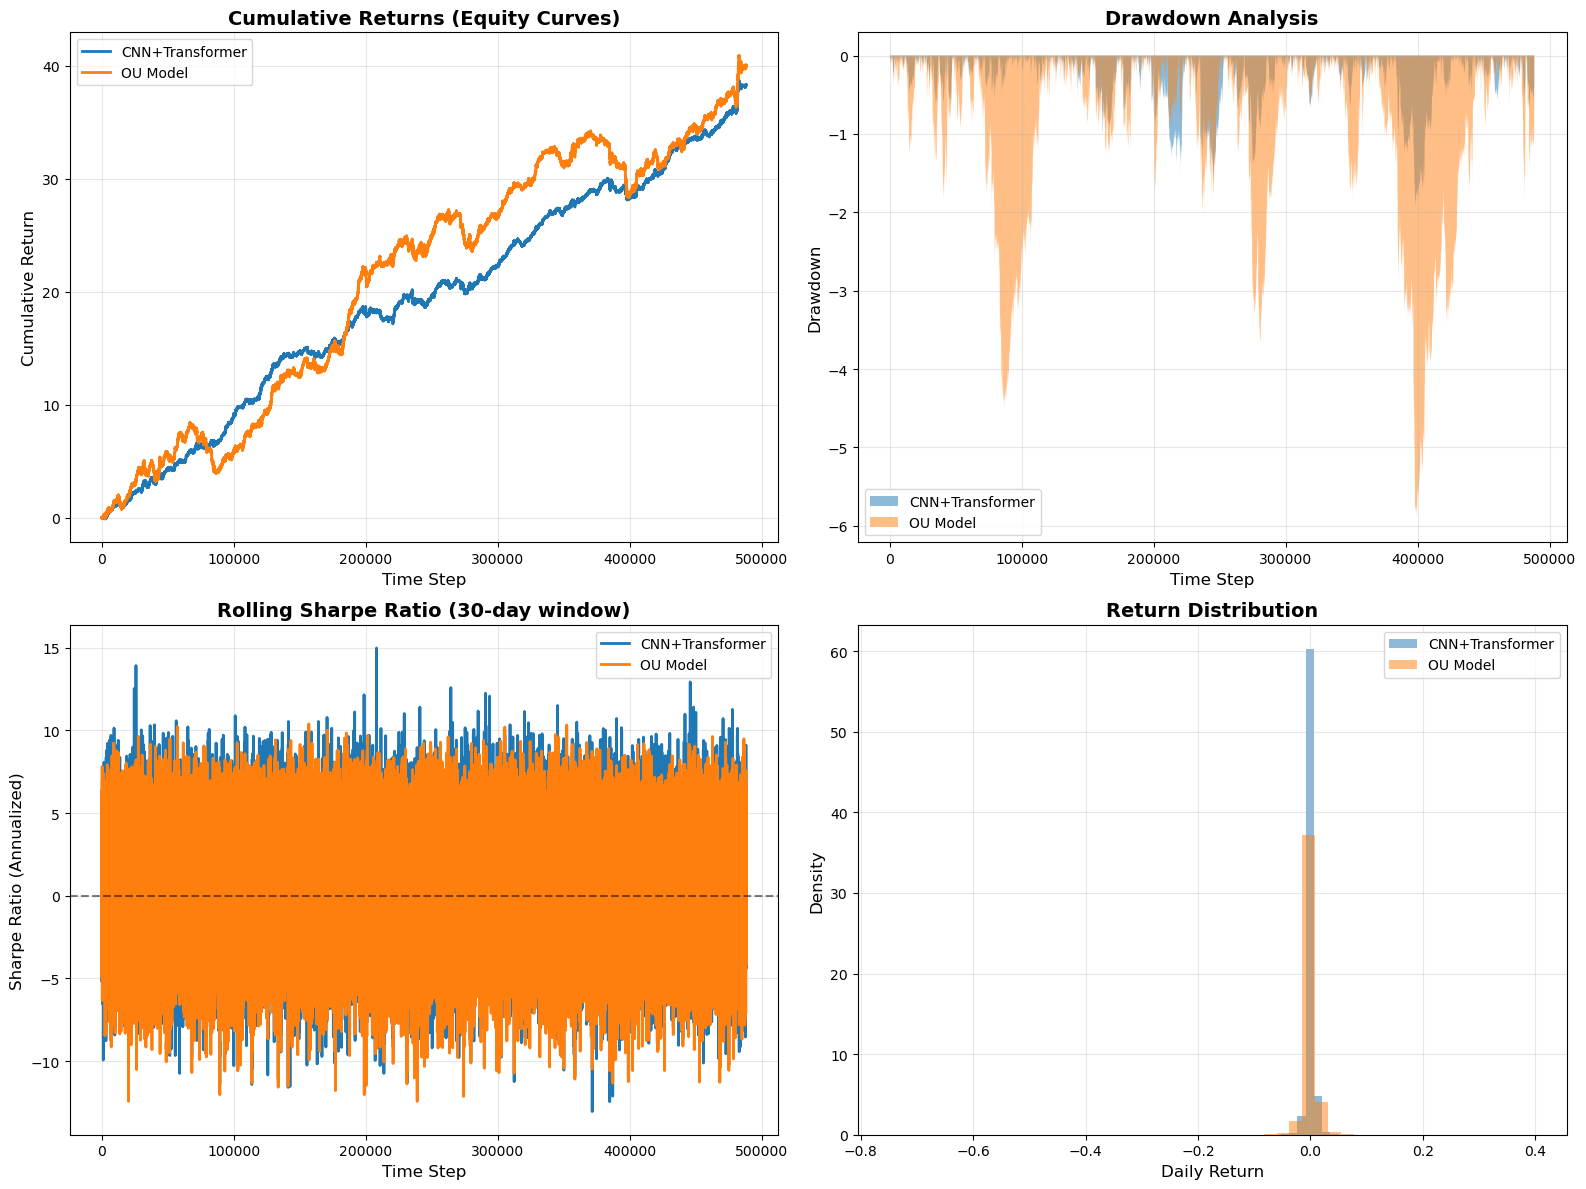

✓ Equity curves ve analiz grafikleri 'equity_curves_and_analysis.png' dosyasına kaydedildi.


In [23]:
# ============================================================================
# 2. EQUITY CURVES VE DRAWDOWN GÖRSELLEŞTİRMELERİ
# ============================================================================

if 'results' in locals() and results:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 2.1 Cumulative Returns (Equity Curves)
    ax1 = axes[0, 0]
    for model_name in results.keys():
        returns = results[model_name]['returns']
        cumulative = np.cumsum(returns)
        ax1.plot(cumulative, label=model_name, linewidth=2)
    ax1.set_title('Cumulative Returns (Equity Curves)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Time Step', fontsize=12)
    ax1.set_ylabel('Cumulative Return', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2.2 Drawdown Analysis
    ax2 = axes[0, 1]
    for model_name in results.keys():
        returns = results[model_name]['returns']
        cumulative = np.cumsum(returns)
        running_max = np.maximum.accumulate(cumulative)
        drawdown = cumulative - running_max
        ax2.fill_between(range(len(drawdown)), drawdown, 0, alpha=0.5, label=model_name)
    ax2.set_title('Drawdown Analysis', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Time Step', fontsize=12)
    ax2.set_ylabel('Drawdown', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 2.3 Rolling Sharpe Ratio (30-day window)
    ax3 = axes[1, 0]
    window = 30
    for model_name in results.keys():
        returns = results[model_name]['returns']
        if len(returns) > window:
            rolling_sharpe = []
            for i in range(window, len(returns)):
                window_returns = returns[i-window:i]
                if np.std(window_returns) > 0:
                    sharpe = (np.mean(window_returns) / np.std(window_returns)) * np.sqrt(252)
                    rolling_sharpe.append(sharpe)
                else:
                    rolling_sharpe.append(0)
            ax3.plot(range(window, len(returns)), rolling_sharpe, label=model_name, linewidth=2)
    ax3.set_title(f'Rolling Sharpe Ratio ({window}-day window)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Time Step', fontsize=12)
    ax3.set_ylabel('Sharpe Ratio (Annualized)', fontsize=12)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    
    # 2.4 Return Distribution
    ax4 = axes[1, 1]
    for model_name in results.keys():
        returns = results[model_name]['returns']
        ax4.hist(returns, bins=50, alpha=0.5, label=model_name, density=True)
    ax4.set_title('Return Distribution', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Daily Return', fontsize=12)
    ax4.set_ylabel('Density', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('equity_curves_and_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Equity curves ve analiz grafikleri 'equity_curves_and_analysis.png' dosyasına kaydedildi.")
else:
    print("⚠ Results bulunamadı. Önce Cell 17'yi çalıştırın.")


PCA RESIDUALS İSTATİSTİKLERİ

Residuals Summary Statistics (ilk 10 hisse):
            Mean       Std  Skewness   Kurtosis       Min       Max
Ticker                                                             
TFC    -0.000172  0.011284 -1.136206  21.657059 -0.153273  0.075982
F      -0.000259  0.015968 -1.248627  19.208185 -0.208543  0.112969
AON     0.000066  0.010993 -0.151345  17.960696 -0.128436  0.091232
BALL   -0.000020  0.013821 -0.581787  26.561666 -0.206139  0.138863
IBKR    0.000040  0.014769 -0.165652   4.643133 -0.110631  0.098498
PSKY   -0.000497  0.023892 -2.175718  34.227386 -0.328733  0.157303
UNP    -0.000015  0.010993  0.265461   8.849160 -0.076314  0.098309
AXON    0.000176  0.026387  0.844535  15.879946 -0.194400  0.254273
DVA     0.000048  0.017774 -3.024030  56.838115 -0.331974  0.131541
VMC    -0.000015  0.014337  0.467913   9.253997 -0.100569  0.142323

Toplam 446 hisse analiz edildi.

--- Genel İstatistikler ---
Ortalama Residual (tüm hisseler): -0.000001
Ort

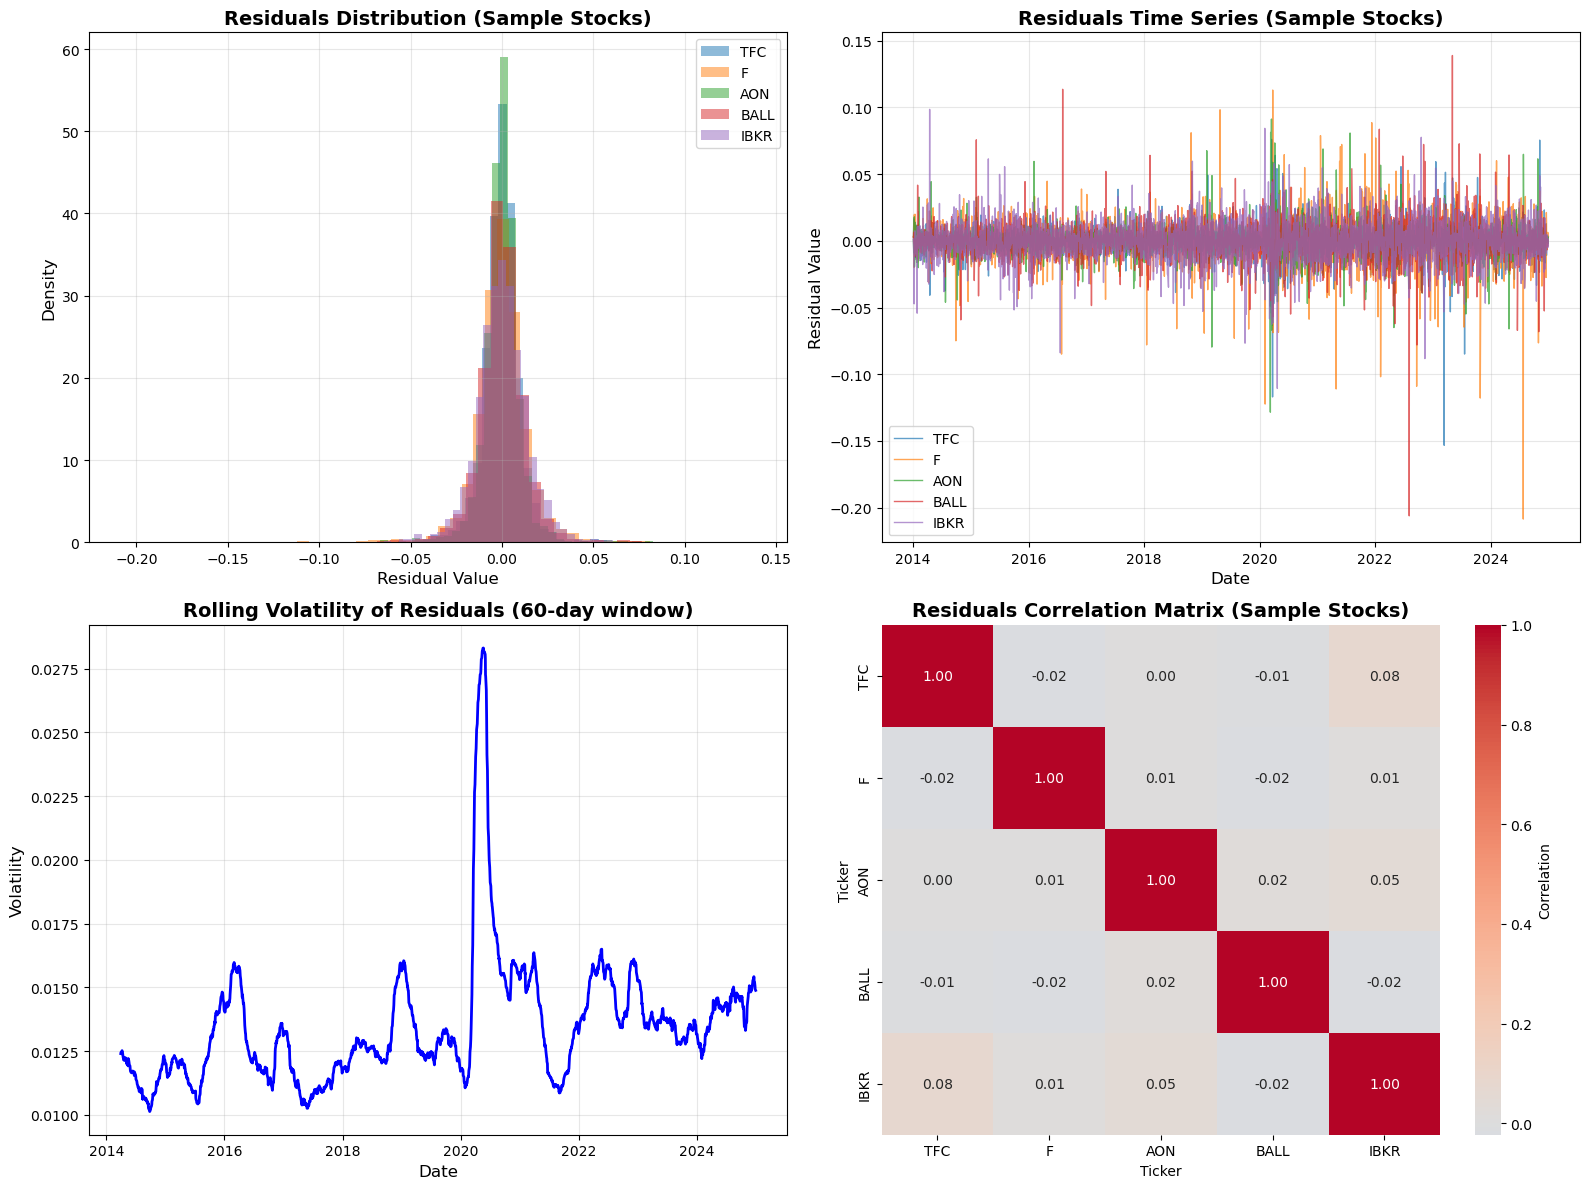


✓ PCA residuals istatistikleri 'pca_residuals_statistics.csv' dosyasına kaydedildi.
✓ PCA residuals analiz grafikleri 'pca_residuals_analysis.png' dosyasına kaydedildi.


In [24]:
# ============================================================================
# 3. PCA RESIDUALS ANALİZİ VE İSTATİSTİKLER
# ============================================================================

if 'residuals_df' in locals() and not residuals_df.empty:
    print("=" * 80)
    print("PCA RESIDUALS İSTATİSTİKLERİ")
    print("=" * 80)
    
    # Residuals summary statistics
    residuals_stats = pd.DataFrame({
        'Mean': residuals_df.mean(),
        'Std': residuals_df.std(),
        'Skewness': residuals_df.skew(),
        'Kurtosis': residuals_df.kurtosis(),
        'Min': residuals_df.min(),
        'Max': residuals_df.max(),
    })
    
    print("\nResiduals Summary Statistics (ilk 10 hisse):")
    print(residuals_stats.head(10).to_string())
    print(f"\nToplam {len(residuals_stats)} hisse analiz edildi.")
    
    # Overall statistics
    print("\n--- Genel İstatistikler ---")
    print(f"Ortalama Residual (tüm hisseler): {residuals_df.mean().mean():.6f}")
    print(f"Ortalama Std (tüm hisseler): {residuals_df.std().mean():.6f}")
    print(f"Ortalama Skewness: {residuals_df.skew().mean():.3f}")
    print(f"Ortalama Kurtosis: {residuals_df.kurtosis().mean():.3f}")
    
    # Residuals distribution visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 3.1 Residuals distribution (sample stocks)
    ax1 = axes[0, 0]
    sample_stocks = residuals_df.columns[:5]  # İlk 5 hisse
    for stock in sample_stocks:
        ax1.hist(residuals_df[stock].dropna(), bins=50, alpha=0.5, label=stock, density=True)
    ax1.set_title('Residuals Distribution (Sample Stocks)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Residual Value', fontsize=12)
    ax1.set_ylabel('Density', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 3.2 Residuals time series (sample stocks)
    ax2 = axes[0, 1]
    for stock in sample_stocks:
        ax2.plot(residuals_df.index, residuals_df[stock], label=stock, alpha=0.7, linewidth=1)
    ax2.set_title('Residuals Time Series (Sample Stocks)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Residual Value', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3.3 Residuals volatility over time
    ax3 = axes[1, 0]
    rolling_vol = residuals_df.std(axis=1).rolling(window=60).mean()
    ax3.plot(rolling_vol.index, rolling_vol.values, linewidth=2, color='blue')
    ax3.set_title('Rolling Volatility of Residuals (60-day window)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Date', fontsize=12)
    ax3.set_ylabel('Volatility', fontsize=12)
    ax3.grid(True, alpha=0.3)
    
    # 3.4 Residuals correlation heatmap (sample stocks)
    ax4 = axes[1, 1]
    sample_corr = residuals_df[sample_stocks].corr()
    import seaborn as sns
    sns.heatmap(sample_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                ax=ax4, cbar_kws={'label': 'Correlation'})
    ax4.set_title('Residuals Correlation Matrix (Sample Stocks)', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('pca_residuals_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # CSV olarak kaydet
    residuals_stats.to_csv('pca_residuals_statistics.csv')
    print("\n✓ PCA residuals istatistikleri 'pca_residuals_statistics.csv' dosyasına kaydedildi.")
    print("✓ PCA residuals analiz grafikleri 'pca_residuals_analysis.png' dosyasına kaydedildi.")
else:
    print("⚠ Residuals DataFrame bulunamadı. Önce Cell 4'ü çalıştırın.")


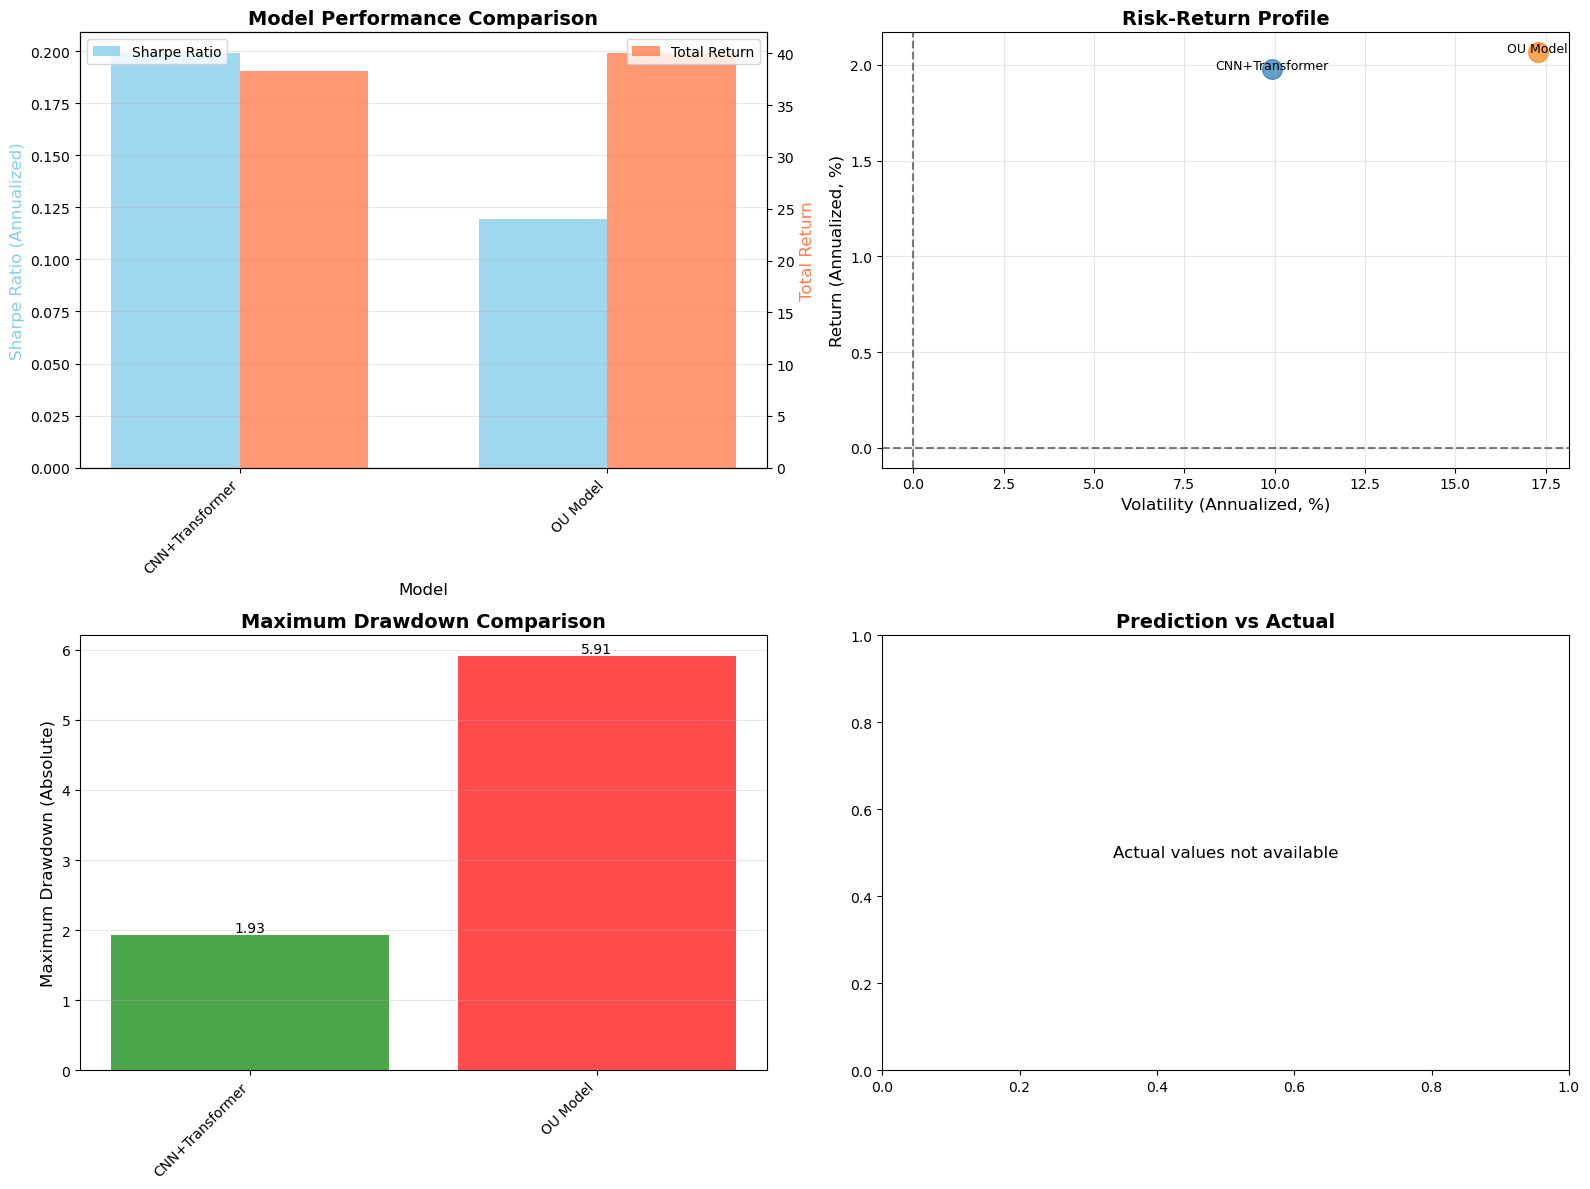

✓ Model karşılaştırma görselleştirmeleri 'model_comparison_visualizations.png' dosyasına kaydedildi.


In [25]:
# ============================================================================
# 4. MODEL KARŞILAŞTIRMA GÖRSELLEŞTİRMELERİ
# ============================================================================

if 'results' in locals() and results:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 4.1 Performance Metrics Comparison (Bar Chart)
    ax1 = axes[0, 0]
    models = list(results.keys())
    sharpe_values = [results[m]['sharpe_annual'] for m in models]
    total_return_values = [results[m]['total_return'] for m in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    ax1_twin = ax1.twinx()
    bars1 = ax1.bar(x - width/2, sharpe_values, width, label='Sharpe Ratio', color='skyblue', alpha=0.8)
    bars2 = ax1_twin.bar(x + width/2, total_return_values, width, label='Total Return', color='coral', alpha=0.8)
    
    ax1.set_xlabel('Model', fontsize=12)
    ax1.set_ylabel('Sharpe Ratio (Annualized)', fontsize=12, color='skyblue')
    ax1_twin.set_ylabel('Total Return', fontsize=12, color='coral')
    ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=45, ha='right')
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 4.2 Risk-Return Scatter
    ax2 = axes[0, 1]
    for model_name in models:
        mean_ret = results[model_name]['mean_return'] * 252 * 100  # Annualized %
        std_ret = results[model_name]['std_return'] * np.sqrt(252) * 100  # Annualized %
        ax2.scatter(std_ret, mean_ret, s=200, alpha=0.7, label=model_name)
        ax2.annotate(model_name, (std_ret, mean_ret), fontsize=9, ha='center')
    ax2.set_xlabel('Volatility (Annualized, %)', fontsize=12)
    ax2.set_ylabel('Return (Annualized, %)', fontsize=12)
    ax2.set_title('Risk-Return Profile', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    
    # 4.3 Max Drawdown Comparison
    ax3 = axes[1, 0]
    max_dd_values = [abs(results[m]['max_drawdown']) for m in models]
    colors = ['red' if dd > 3 else 'orange' if dd > 2 else 'green' for dd in max_dd_values]
    bars = ax3.bar(models, max_dd_values, color=colors, alpha=0.7)
    ax3.set_ylabel('Maximum Drawdown (Absolute)', fontsize=12)
    ax3.set_title('Maximum Drawdown Comparison', fontsize=14, fontweight='bold')
    ax3.set_xticklabels(models, rotation=45, ha='right')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, max_dd_values):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}', ha='center', va='bottom', fontsize=10)
    
    # 4.4 Prediction vs Actual (if available)
    ax4 = axes[1, 1]
    if 'CNN+Transformer' in results and 'predictions' in results['CNN+Transformer']:
        predictions = results['CNN+Transformer']['predictions']
        actual = results['CNN+Transformer'].get('actual', None)
        if actual is not None and len(actual) == len(predictions):
            ax4.scatter(actual, predictions, alpha=0.5, s=10)
            min_val = min(min(actual), min(predictions))
            max_val = max(max(actual), max(predictions))
            ax4.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
            ax4.set_xlabel('Actual Returns', fontsize=12)
            ax4.set_ylabel('Predicted Returns', fontsize=12)
            ax4.set_title('Prediction vs Actual (CNN+Transformer)', fontsize=14, fontweight='bold')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
        else:
            ax4.text(0.5, 0.5, 'Actual values not available', 
                    ha='center', va='center', transform=ax4.transAxes, fontsize=12)
            ax4.set_title('Prediction vs Actual', fontsize=14, fontweight='bold')
    else:
        ax4.text(0.5, 0.5, 'Predictions not available', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Prediction vs Actual', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('model_comparison_visualizations.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Model karşılaştırma görselleştirmeleri 'model_comparison_visualizations.png' dosyasına kaydedildi.")
else:
    print("⚠ Results bulunamadı. Önce Cell 17'yi çalıştırın.")


In [26]:
# ============================================================================
# 5. ÖZET RAPOR: TÜM ÇIKTILARIN ÖZETİ
# ============================================================================

print("=" * 80)
print("PROJE ÇIKTILARI ÖZET RAPORU")
print("=" * 80)
print("\nGrup Üyeleri: Sezin Biner (046808) | Umut Kaya (050742)")
print("Proje: Designing a Machine Learning–Based Statistical Arbitrage Strategy for Pairs Trading")
print("\n" + "=" * 80)

# 1. Data Summary
if 'prices_df' in locals():
    print("\n1. VERİ ÖZETİ:")
    print(f"   - Toplam Tarih: {len(prices_df)} gün")
    print(f"   - Tarih Aralığı: {prices_df.index[0].date()} - {prices_df.index[-1].date()}")
    print(f"   - Toplam Hisse Sayısı: {len(prices_df.columns)}")
    print(f"   - Veri Kaynağı: S&P 500 (yfinance)")

# 2. PCA Residuals Summary
if 'residuals_df' in locals() and not residuals_df.empty:
    print("\n2. PCA RESIDUALS ÖZETİ:")
    print(f"   - Residuals DataFrame Shape: {residuals_df.shape}")
    print(f"   - PCA Components: 5")
    print(f"   - Window Size: 252 gün")
    print(f"   - Ortalama Residual Std: {residuals_df.std().mean():.6f}")
    print(f"   - Residuals Coverage: {(residuals_df.notna().sum().sum() / (residuals_df.shape[0] * residuals_df.shape[1]) * 100):.1f}%")

# 3. Model Performance Summary
if 'results' in locals() and results:
    print("\n3. MODEL PERFORMANS ÖZETİ:")
    best_sharpe_model = max(results.keys(), key=lambda m: results[m]['sharpe_annual'])
    best_return_model = max(results.keys(), key=lambda m: results[m]['total_return'])
    best_dd_model = min(results.keys(), key=lambda m: results[m]['max_drawdown'])
    
    print(f"   - En İyi Sharpe Ratio: {best_sharpe_model} ({results[best_sharpe_model]['sharpe_annual']:.4f})")
    print(f"   - En İyi Total Return: {best_return_model} ({results[best_return_model]['total_return']:.2f})")
    print(f"   - En Düşük Drawdown: {best_dd_model} ({results[best_dd_model]['max_drawdown']:.2f})")
    print(f"   - Test Edilen Model Sayısı: {len(results)}")

# 4. Generated Files
print("\n4. OLUŞTURULAN DOSYALAR:")
files_created = []
if 'performance_df' in locals():
    files_created.append("   - performance_metrics.csv")
if 'residuals_stats' in locals():
    files_created.append("   - pca_residuals_statistics.csv")
if files_created:
    for f in files_created:
        print(f)
else:
    print("   (Dosyalar oluşturulmak için yukarıdaki cell'leri çalıştırın)")

print("\n5. GÖRSELLEŞTİRMELER:")
print("   - equity_curves_and_analysis.png")
print("   - pca_residuals_analysis.png")
print("   - model_comparison_visualizations.png")

print("\n" + "=" * 80)
print("RAPOR TAMAMLANDI")
print("=" * 80)


PROJE ÇIKTILARI ÖZET RAPORU

Grup Üyeleri: Sezin Biner (046808) | Umut Kaya (050742)
Proje: Designing a Machine Learning–Based Statistical Arbitrage Strategy for Pairs Trading


1. VERİ ÖZETİ:
   - Toplam Tarih: 3773 gün
   - Tarih Aralığı: 2010-01-04 - 2024-12-30
   - Toplam Hisse Sayısı: 446
   - Veri Kaynağı: S&P 500 (yfinance)

2. PCA RESIDUALS ÖZETİ:
   - Residuals DataFrame Shape: (2766, 446)
   - PCA Components: 5
   - Window Size: 252 gün
   - Ortalama Residual Std: 0.013655
   - Residuals Coverage: 100.0%

3. MODEL PERFORMANS ÖZETİ:
   - En İyi Sharpe Ratio: CNN+Transformer (0.1992)
   - En İyi Total Return: OU Model (40.04)
   - En Düşük Drawdown: OU Model (-5.91)
   - Test Edilen Model Sayısı: 2

4. OLUŞTURULAN DOSYALAR:
   - performance_metrics.csv
   - pca_residuals_statistics.csv

5. GÖRSELLEŞTİRMELER:
   - equity_curves_and_analysis.png
   - pca_residuals_analysis.png
   - model_comparison_visualizations.png

RAPOR TAMAMLANDI
